In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
#FOLD=int(os.getenv("FOLD"))

In [3]:
FOLD=0

In [4]:
print FOLD

0


In [5]:
sys.path.insert(0,"../python/rrvf2017/")

In [6]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [7]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [8]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [9]:
gc.collect()

0

# cv

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=True
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3001eb_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (162481, 2) (41472, 2)
rand split across time
train has 162481 records out of 389630 records
valid has 41472 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1269
0
(162481, 1, 18) (162481, 7, 32) (162481, 1) (162481, 1)
(162481, 242) (162481,) (162481,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boos

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.80476
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783303
[3]	valid_0's rmse: 0.763019
[4]	valid_0's rmse: 0.74436
[5]	valid_0's rmse: 0.726719
[6]	valid_0's rmse: 0.710657
[7]	valid_0's rmse: 0.695838
[8]	valid_0's rmse: 0.682035
[9]	valid_0's rmse: 0.669275
[10]	valid_0's rmse: 0.65744
[11]	valid_0's rmse: 0.64676
[12]	valid_0's rmse: 0.636576
[13]	valid_0's rmse: 0.627512
[14]	valid_0's rmse: 0.6189
[15]	valid_0's rmse: 0.611132
[16]	valid_0's rmse: 0.603828
[17]	valid_0's rmse: 0.597268
[18]	valid_0's rmse: 0.591044
[19]	valid_0's rmse: 0.585433
[20]	valid_0's rmse: 0.580197
[21]	valid_0's rmse: 0.575457
[22]	valid_0's rmse: 0.571203
[23]	valid_0's rmse: 0.567283
[24]	valid_0's rmse: 0.563646
[25]	valid_0's rmse: 0.560371
[26]	valid_0's rmse: 0.557161
[27]	valid_0's rmse: 0.554338
[28]	valid_0's rmse: 0.55175
[29]	valid_0's rmse: 0.549279
[30]	valid_0's rmse: 0.547022
[31]	valid_0's rmse: 0.545001
[32]	valid_0's rmse: 0.5

[270]	valid_0's rmse: 0.513305
[271]	valid_0's rmse: 0.513304
[272]	valid_0's rmse: 0.513294
[273]	valid_0's rmse: 0.513293
[274]	valid_0's rmse: 0.513285
[275]	valid_0's rmse: 0.513272
[276]	valid_0's rmse: 0.513271
[277]	valid_0's rmse: 0.51326
[278]	valid_0's rmse: 0.513267
[279]	valid_0's rmse: 0.513267
[280]	valid_0's rmse: 0.513276
[281]	valid_0's rmse: 0.513265
[282]	valid_0's rmse: 0.513257
[283]	valid_0's rmse: 0.513264
[284]	valid_0's rmse: 0.513259
[285]	valid_0's rmse: 0.513255
[286]	valid_0's rmse: 0.513255
[287]	valid_0's rmse: 0.513262
[288]	valid_0's rmse: 0.513252
[289]	valid_0's rmse: 0.513242
[290]	valid_0's rmse: 0.513258
[291]	valid_0's rmse: 0.513246
[292]	valid_0's rmse: 0.513239
[293]	valid_0's rmse: 0.513229
[294]	valid_0's rmse: 0.51322
[295]	valid_0's rmse: 0.513224
[296]	valid_0's rmse: 0.513221
[297]	valid_0's rmse: 0.513224
[298]	valid_0's rmse: 0.513226
[299]	valid_0's rmse: 0.513229
[300]	valid_0's rmse: 0.513222
[301]	valid_0's rmse: 0.51323
[302]	valid

[535]	valid_0's rmse: 0.512537
[536]	valid_0's rmse: 0.512547
[537]	valid_0's rmse: 0.512542
[538]	valid_0's rmse: 0.512539
[539]	valid_0's rmse: 0.512536
[540]	valid_0's rmse: 0.512522
[541]	valid_0's rmse: 0.51253
[542]	valid_0's rmse: 0.512527
[543]	valid_0's rmse: 0.51252
[544]	valid_0's rmse: 0.512512
[545]	valid_0's rmse: 0.512506
[546]	valid_0's rmse: 0.512502
[547]	valid_0's rmse: 0.512503
[548]	valid_0's rmse: 0.512505
[549]	valid_0's rmse: 0.512504
[550]	valid_0's rmse: 0.5125
[551]	valid_0's rmse: 0.512504
[552]	valid_0's rmse: 0.512515
[553]	valid_0's rmse: 0.512508
[554]	valid_0's rmse: 0.512496
[555]	valid_0's rmse: 0.512492
[556]	valid_0's rmse: 0.512491
[557]	valid_0's rmse: 0.512491
[558]	valid_0's rmse: 0.512505
[559]	valid_0's rmse: 0.512507
[560]	valid_0's rmse: 0.512504
[561]	valid_0's rmse: 0.512498
[562]	valid_0's rmse: 0.512501
[563]	valid_0's rmse: 0.512495
[564]	valid_0's rmse: 0.512496
[565]	valid_0's rmse: 0.512508
[566]	valid_0's rmse: 0.512523
[567]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914673  0.014437  0.131769    7  2017-04-16
472     2.507290  2.525860 -0.018569  0.121966    1  2017-04-17
473     2.661330  2.661341 -0.000011  0.131986    2  2017-04-18
474     2.754815  2.739431  0.015384  0.124804    3  2017-04-19
475     2.713762  2.714075 -0.000313  0.135804    4  2017-04-20
476     2.999000  2.983641  0.015359  0.090480    5  2017-04-21
477     3.075529  3.083249 -0.007719  0.112870    6  2017-04-22

0.121382629067


pred         y     error    error2  day        date
dayidx                                                         
471     2.914673  2.929110  0.014437  0.131769    7  2017-04-16
472     2.525860  2.507290 -0.018569  0.121966    1  2017-04-17
473     2.661341  2.661330 -0.000011  0.131986    2  2017-04-18
474     2.739431  2.754815  0.015384  0.124804    3  2017-04-19
475     2.714075  2.713762 -0.000313  0.135804    4  2017-04-20
476     2.983641  2.999000  0.015359  0.090480    5  2017-04-21
477     3.083249  3.075529 -0.007719  0.112870    6  2017-04-22

(829, 242)


2
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (167833, 2) (42755, 2)
rand split across time
train has 167833 records out of 389630 records
valid has 42755 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1311
0
(167833, 1, 18) (167833, 7, 32) (167833, 1) (167833, 1)
(167833, 242) (167833,) (167833,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0

[237]	valid_0's rmse: 0.507952
[238]	valid_0's rmse: 0.507936
[239]	valid_0's rmse: 0.507931
[240]	valid_0's rmse: 0.507925
[241]	valid_0's rmse: 0.507923
[242]	valid_0's rmse: 0.50792
[243]	valid_0's rmse: 0.50794
[244]	valid_0's rmse: 0.507925
[245]	valid_0's rmse: 0.50793
[246]	valid_0's rmse: 0.507929
[247]	valid_0's rmse: 0.507919
[248]	valid_0's rmse: 0.50791
[249]	valid_0's rmse: 0.507899
[250]	valid_0's rmse: 0.507896
[251]	valid_0's rmse: 0.507892
[252]	valid_0's rmse: 0.507879
[253]	valid_0's rmse: 0.507869
[254]	valid_0's rmse: 0.507866
[255]	valid_0's rmse: 0.507865
[256]	valid_0's rmse: 0.507875
[257]	valid_0's rmse: 0.50787
[258]	valid_0's rmse: 0.507848
[259]	valid_0's rmse: 0.507857
[260]	valid_0's rmse: 0.507865
[261]	valid_0's rmse: 0.507846
[262]	valid_0's rmse: 0.507842
[263]	valid_0's rmse: 0.507826
[264]	valid_0's rmse: 0.507809
[265]	valid_0's rmse: 0.507804
[266]	valid_0's rmse: 0.507814
[267]	valid_0's rmse: 0.507836
[268]	valid_0's rmse: 0.507822
[269]	valid_0

[504]	valid_0's rmse: 0.506937
[505]	valid_0's rmse: 0.506929
[506]	valid_0's rmse: 0.506943
[507]	valid_0's rmse: 0.50694
[508]	valid_0's rmse: 0.506944
[509]	valid_0's rmse: 0.506944
[510]	valid_0's rmse: 0.50695
[511]	valid_0's rmse: 0.506958
Early stopping, best iteration is:
[461]	valid_0's rmse: 0.506903
0.0587939004606 0.256950212641
[0.25695021264058132]
-1 mean score 0.256950212641
0.144760233378


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915173  0.013937  0.155651    7  2017-04-16
472     2.507290  2.535902 -0.028611  0.166161    1  2017-04-17
473     2.661330  2.668858 -0.007528  0.161715    2  2017-04-18
474     2.754815  2.734606  0.020208  0.135120    3  2017-04-19
475     2.713762  2.710065  0.003697  0.159963    4  2017-04-20
476     2.999000  2.993674  0.005325  0.107723    5  2017-04-21
477     3.075529  3.086416 -0.010887  0.126988    6  2017-04-22

0.144760233378


pred         y     error    error2  day        date
dayidx                                                         
471     2.915173  2.929110  0.013937  0.155651    7  2017-04-16
472     2.535902  2.507290 -0.028611  0.166161    1  2017-04-17
473     2.668858  2.661330 -0.007528  0.161715    2  2017-04-18
474     2.734606  2.754815  0.020208  0.135120    3  2017-04-19
475     2.710065  2.713762  0.003697  0.159963    4  2017-04-20
476     2.993674  2.999000  0.005325  0.107723    5  2017-04-21
477     3.086416  3.075529 -0.010887  0.126988    6  2017-04-22

(829, 242)


3
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (168342, 2) (42828, 2)
rand split across time
train has 168342 records out of 389630 records
valid has 42828 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1315
0
(168342, 1, 18) (168342, 7, 32) (168342, 1) (168342, 1)
(168342, 242) (168342,) (168342,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(7461, 1, 18) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 242) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0

[238]	valid_0's rmse: 0.513324
[239]	valid_0's rmse: 0.513312
[240]	valid_0's rmse: 0.513306
[241]	valid_0's rmse: 0.51332
[242]	valid_0's rmse: 0.513322
[243]	valid_0's rmse: 0.513314
[244]	valid_0's rmse: 0.513308
[245]	valid_0's rmse: 0.513297
[246]	valid_0's rmse: 0.513268
[247]	valid_0's rmse: 0.513268
[248]	valid_0's rmse: 0.513259
[249]	valid_0's rmse: 0.513239
[250]	valid_0's rmse: 0.51322
[251]	valid_0's rmse: 0.513208
[252]	valid_0's rmse: 0.513185
[253]	valid_0's rmse: 0.513149
[254]	valid_0's rmse: 0.513143
[255]	valid_0's rmse: 0.513158
[256]	valid_0's rmse: 0.513145
[257]	valid_0's rmse: 0.513152
[258]	valid_0's rmse: 0.513135
[259]	valid_0's rmse: 0.513117
[260]	valid_0's rmse: 0.513097
[261]	valid_0's rmse: 0.513093
[262]	valid_0's rmse: 0.513101
[263]	valid_0's rmse: 0.513091
[264]	valid_0's rmse: 0.513079
[265]	valid_0's rmse: 0.513064
[266]	valid_0's rmse: 0.513044
[267]	valid_0's rmse: 0.513043
[268]	valid_0's rmse: 0.513053
[269]	valid_0's rmse: 0.513045
[270]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915017  0.014093  0.154246    7  2017-04-16
472     2.507290  2.529837 -0.022547  0.140988    1  2017-04-17
473     2.661330  2.671752 -0.010422  0.178500    2  2017-04-18
474     2.754815  2.754732  0.000083  0.161969    3  2017-04-19
475     2.713762  2.717363 -0.003602  0.165755    4  2017-04-20
476     2.999000  2.992913  0.006087  0.105780    5  2017-04-21
477     3.075529  3.091371 -0.015841  0.127580    6  2017-04-22

0.147831246197


pred         y     error    error2  day        date
dayidx                                                         
471     2.915017  2.929110  0.014093  0.154246    7  2017-04-16
472     2.529837  2.507290 -0.022547  0.140988    1  2017-04-17
473     2.671752  2.661330 -0.010422  0.178500    2  2017-04-18
474     2.754732  2.754815  0.000083  0.161969    3  2017-04-19
475     2.717363  2.713762 -0.003602  0.165755    4  2017-04-20
476     2.992913  2.999000  0.006087  0.105780    5  2017-04-21
477     3.091371  3.075529 -0.015841  0.127580    6  2017-04-22

(829, 242)


4
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (168418, 2) (42877, 2)
rand split across time
train has 168418 records out of 389630 records
valid has 42877 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1315
0
(168418, 1, 18) (168418, 7, 32) (168418, 1) (168418, 1)
(168418, 242) (168418,) (168418,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(8290, 1, 18) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 242) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0

[237]	valid_0's rmse: 0.513345
[238]	valid_0's rmse: 0.513351
[239]	valid_0's rmse: 0.513343
[240]	valid_0's rmse: 0.513346
[241]	valid_0's rmse: 0.513354
[242]	valid_0's rmse: 0.513357
[243]	valid_0's rmse: 0.513351
[244]	valid_0's rmse: 0.51335
[245]	valid_0's rmse: 0.513341
[246]	valid_0's rmse: 0.513327
[247]	valid_0's rmse: 0.513315
[248]	valid_0's rmse: 0.513318
[249]	valid_0's rmse: 0.513308
[250]	valid_0's rmse: 0.513314
[251]	valid_0's rmse: 0.513322
[252]	valid_0's rmse: 0.513297
[253]	valid_0's rmse: 0.513263
[254]	valid_0's rmse: 0.513263
[255]	valid_0's rmse: 0.513257
[256]	valid_0's rmse: 0.513259
[257]	valid_0's rmse: 0.51326
[258]	valid_0's rmse: 0.513277
[259]	valid_0's rmse: 0.513273
[260]	valid_0's rmse: 0.513287
[261]	valid_0's rmse: 0.513279
[262]	valid_0's rmse: 0.513257
[263]	valid_0's rmse: 0.513267
[264]	valid_0's rmse: 0.51327
[265]	valid_0's rmse: 0.513286
[266]	valid_0's rmse: 0.513287
[267]	valid_0's rmse: 0.513286
[268]	valid_0's rmse: 0.513297
[269]	valid

[505]	valid_0's rmse: 0.512549
[506]	valid_0's rmse: 0.512554
[507]	valid_0's rmse: 0.512545
[508]	valid_0's rmse: 0.51255
[509]	valid_0's rmse: 0.512549
[510]	valid_0's rmse: 0.512549
[511]	valid_0's rmse: 0.51254
[512]	valid_0's rmse: 0.512518
[513]	valid_0's rmse: 0.512515
[514]	valid_0's rmse: 0.512499
[515]	valid_0's rmse: 0.512495
[516]	valid_0's rmse: 0.512507
[517]	valid_0's rmse: 0.51251
[518]	valid_0's rmse: 0.51251
[519]	valid_0's rmse: 0.512513
[520]	valid_0's rmse: 0.512519
[521]	valid_0's rmse: 0.512519
[522]	valid_0's rmse: 0.512517
[523]	valid_0's rmse: 0.512503
[524]	valid_0's rmse: 0.51252
[525]	valid_0's rmse: 0.512523
[526]	valid_0's rmse: 0.512513
[527]	valid_0's rmse: 0.512502
[528]	valid_0's rmse: 0.51249
[529]	valid_0's rmse: 0.512497
[530]	valid_0's rmse: 0.512507
[531]	valid_0's rmse: 0.512516
[532]	valid_0's rmse: 0.512524
[533]	valid_0's rmse: 0.512535
[534]	valid_0's rmse: 0.512537
[535]	valid_0's rmse: 0.512548
[536]	valid_0's rmse: 0.512543
[537]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905010  0.024100  0.142709    7  2017-04-16
472     2.507290  2.529218 -0.021927  0.126524    1  2017-04-17
473     2.661330  2.663983 -0.002654  0.143768    2  2017-04-18
474     2.754815  2.739267  0.015548  0.137445    3  2017-04-19
475     2.713762  2.716427 -0.002666  0.167616    4  2017-04-20
476     2.999000  2.976741  0.022259  0.095986    5  2017-04-21
477     3.075529  3.071681  0.003848  0.115029    6  2017-04-22

0.132725220105


pred         y     error    error2  day        date
dayidx                                                         
471     2.905010  2.929110  0.024100  0.142709    7  2017-04-16
472     2.529218  2.507290 -0.021927  0.126524    1  2017-04-17
473     2.663983  2.661330 -0.002654  0.143768    2  2017-04-18
474     2.739267  2.754815  0.015548  0.137445    3  2017-04-19
475     2.716427  2.713762 -0.002666  0.167616    4  2017-04-20
476     2.976741  2.999000  0.022259  0.095986    5  2017-04-21
477     3.071681  3.075529  0.003848  0.115029    6  2017-04-22

(829, 242)


5
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (168541, 2) (42951, 2)
rand split across time
train has 168541 records out of 389630 records
valid has 42951 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1316
0
(168541, 1, 18) (168541, 7, 32) (168541, 1) (168541, 1)
(168541, 242) (168541,) (168541,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 242) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0

[237]	valid_0's rmse: 0.513548
[238]	valid_0's rmse: 0.513546
[239]	valid_0's rmse: 0.513532
[240]	valid_0's rmse: 0.513542
[241]	valid_0's rmse: 0.513528
[242]	valid_0's rmse: 0.513511
[243]	valid_0's rmse: 0.513497
[244]	valid_0's rmse: 0.513479
[245]	valid_0's rmse: 0.513469
[246]	valid_0's rmse: 0.51349
[247]	valid_0's rmse: 0.5135
[248]	valid_0's rmse: 0.513505
[249]	valid_0's rmse: 0.513495
[250]	valid_0's rmse: 0.51349
[251]	valid_0's rmse: 0.513477
[252]	valid_0's rmse: 0.513449
[253]	valid_0's rmse: 0.513445
[254]	valid_0's rmse: 0.513439
[255]	valid_0's rmse: 0.513442
[256]	valid_0's rmse: 0.513435
[257]	valid_0's rmse: 0.513427
[258]	valid_0's rmse: 0.513416
[259]	valid_0's rmse: 0.513397
[260]	valid_0's rmse: 0.513395
[261]	valid_0's rmse: 0.513394
[262]	valid_0's rmse: 0.51338
[263]	valid_0's rmse: 0.513369
[264]	valid_0's rmse: 0.513364
[265]	valid_0's rmse: 0.513359
[266]	valid_0's rmse: 0.513375
[267]	valid_0's rmse: 0.513373
[268]	valid_0's rmse: 0.513374
[269]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903315  0.025795  0.177375    7  2017-04-16
472     2.507290  2.538622 -0.031332  0.160635    1  2017-04-17
473     2.661330  2.660553  0.000777  0.169643    2  2017-04-18
474     2.754815  2.751145  0.003670  0.157643    3  2017-04-19
475     2.713762  2.733173 -0.019412  0.198324    4  2017-04-20
476     2.999000  2.997742  0.001258  0.125191    5  2017-04-21
477     3.075529  3.084653 -0.009124  0.140417    6  2017-04-22

0.161318205131


pred         y     error    error2  day        date
dayidx                                                         
471     2.903315  2.929110  0.025795  0.177375    7  2017-04-16
472     2.538622  2.507290 -0.031332  0.160635    1  2017-04-17
473     2.660553  2.661330  0.000777  0.169643    2  2017-04-18
474     2.751145  2.754815  0.003670  0.157643    3  2017-04-19
475     2.733173  2.713762 -0.019412  0.198324    4  2017-04-20
476     2.997742  2.999000  0.001258  0.125191    5  2017-04-21
477     3.084653  3.075529 -0.009124  0.140417    6  2017-04-22

(829, 242)


6
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (168444, 2) (42973, 2)
rand split across time
train has 168444 records out of 389630 records
valid has 42973 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1315
0
(168444, 1, 18) (168444, 7, 32) (168444, 1) (168444, 1)
(168444, 242) (168444,) (168444,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 242) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0

[235]	valid_0's rmse: 0.514173
[236]	valid_0's rmse: 0.514176
[237]	valid_0's rmse: 0.51418
[238]	valid_0's rmse: 0.514183
[239]	valid_0's rmse: 0.514176
[240]	valid_0's rmse: 0.514184
[241]	valid_0's rmse: 0.514174
[242]	valid_0's rmse: 0.514171
[243]	valid_0's rmse: 0.514187
[244]	valid_0's rmse: 0.514186
[245]	valid_0's rmse: 0.51419
[246]	valid_0's rmse: 0.514201
[247]	valid_0's rmse: 0.514204
[248]	valid_0's rmse: 0.514178
[249]	valid_0's rmse: 0.514167
[250]	valid_0's rmse: 0.514156
[251]	valid_0's rmse: 0.514157
[252]	valid_0's rmse: 0.514151
[253]	valid_0's rmse: 0.514153
[254]	valid_0's rmse: 0.514129
[255]	valid_0's rmse: 0.514134
[256]	valid_0's rmse: 0.514124
[257]	valid_0's rmse: 0.514111
[258]	valid_0's rmse: 0.514123
[259]	valid_0's rmse: 0.514117
[260]	valid_0's rmse: 0.514099
[261]	valid_0's rmse: 0.514083
[262]	valid_0's rmse: 0.514073
[263]	valid_0's rmse: 0.514084
[264]	valid_0's rmse: 0.514095
[265]	valid_0's rmse: 0.514083
[266]	valid_0's rmse: 0.51407
[267]	valid

[503]	valid_0's rmse: 0.513601
[504]	valid_0's rmse: 0.513595
[505]	valid_0's rmse: 0.513598
[506]	valid_0's rmse: 0.513597
[507]	valid_0's rmse: 0.513607
[508]	valid_0's rmse: 0.513598
[509]	valid_0's rmse: 0.513603
[510]	valid_0's rmse: 0.513611
[511]	valid_0's rmse: 0.513599
[512]	valid_0's rmse: 0.513595
[513]	valid_0's rmse: 0.513584
[514]	valid_0's rmse: 0.513582
[515]	valid_0's rmse: 0.513586
[516]	valid_0's rmse: 0.513605
[517]	valid_0's rmse: 0.513602
[518]	valid_0's rmse: 0.513612
[519]	valid_0's rmse: 0.513606
[520]	valid_0's rmse: 0.513626
[521]	valid_0's rmse: 0.513624
[522]	valid_0's rmse: 0.513623
[523]	valid_0's rmse: 0.513629
[524]	valid_0's rmse: 0.513626
[525]	valid_0's rmse: 0.513631
[526]	valid_0's rmse: 0.513639
[527]	valid_0's rmse: 0.513642
[528]	valid_0's rmse: 0.513648
[529]	valid_0's rmse: 0.513647
[530]	valid_0's rmse: 0.513639
[531]	valid_0's rmse: 0.513625
[532]	valid_0's rmse: 0.513625
[533]	valid_0's rmse: 0.513612
[534]	valid_0's rmse: 0.513602
[535]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911992  0.017118  0.155217    7  2017-04-16
472     2.507290  2.532467 -0.025176  0.128830    1  2017-04-17
473     2.661330  2.648386  0.012944  0.140737    2  2017-04-18
474     2.754815  2.742519  0.012296  0.125195    3  2017-04-19
475     2.713762  2.721577 -0.007815  0.143067    4  2017-04-20
476     2.999000  2.970289  0.028711  0.106199    5  2017-04-21
477     3.075529  3.087226 -0.011697  0.124299    6  2017-04-22

0.131934776043


pred         y     error    error2  day        date
dayidx                                                         
471     2.911992  2.929110  0.017118  0.155217    7  2017-04-16
472     2.532467  2.507290 -0.025176  0.128830    1  2017-04-17
473     2.648386  2.661330  0.012944  0.140737    2  2017-04-18
474     2.742519  2.754815  0.012296  0.125195    3  2017-04-19
475     2.721577  2.713762 -0.007815  0.143067    4  2017-04-20
476     2.970289  2.999000  0.028711  0.106199    5  2017-04-21
477     3.087226  3.075529 -0.011697  0.124299    6  2017-04-22

(829, 242)


7
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (168840, 2) (43045, 2)
rand split across time
train has 168840 records out of 389630 records
valid has 43045 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1319
0
(168840, 1, 18) (168840, 7, 32) (168840, 1) (168840, 1)
(168840, 242) (168840,) (168840,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 242) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in

[236]	valid_0's rmse: 0.512393
[237]	valid_0's rmse: 0.51238
[238]	valid_0's rmse: 0.51237
[239]	valid_0's rmse: 0.512377
[240]	valid_0's rmse: 0.512368
[241]	valid_0's rmse: 0.512349
[242]	valid_0's rmse: 0.512342
[243]	valid_0's rmse: 0.512317
[244]	valid_0's rmse: 0.512308
[245]	valid_0's rmse: 0.512299
[246]	valid_0's rmse: 0.512301
[247]	valid_0's rmse: 0.512305
[248]	valid_0's rmse: 0.512289
[249]	valid_0's rmse: 0.512288
[250]	valid_0's rmse: 0.512294
[251]	valid_0's rmse: 0.512283
[252]	valid_0's rmse: 0.512284
[253]	valid_0's rmse: 0.51227
[254]	valid_0's rmse: 0.512272
[255]	valid_0's rmse: 0.512283
[256]	valid_0's rmse: 0.51227
[257]	valid_0's rmse: 0.512245
[258]	valid_0's rmse: 0.512245
[259]	valid_0's rmse: 0.51223
[260]	valid_0's rmse: 0.512199
[261]	valid_0's rmse: 0.512205
[262]	valid_0's rmse: 0.512197
[263]	valid_0's rmse: 0.512198
[264]	valid_0's rmse: 0.512208
[265]	valid_0's rmse: 0.51221
[266]	valid_0's rmse: 0.512206
[267]	valid_0's rmse: 0.512206
[268]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908027  0.021083  0.182392    7  2017-04-16
472     2.507290  2.539788 -0.032497  0.151743    1  2017-04-17
473     2.661330  2.656555  0.004775  0.171575    2  2017-04-18
474     2.754815  2.743460  0.011355  0.152241    3  2017-04-19
475     2.713762  2.714233 -0.000471  0.161939    4  2017-04-20
476     2.999000  2.981975  0.017024  0.108010    5  2017-04-21
477     3.075529  3.117611 -0.042082  0.154720    6  2017-04-22

0.154659903633


pred         y     error    error2  day        date
dayidx                                                         
471     2.908027  2.929110  0.021083  0.182392    7  2017-04-16
472     2.539788  2.507290 -0.032497  0.151743    1  2017-04-17
473     2.656555  2.661330  0.004775  0.171575    2  2017-04-18
474     2.743460  2.754815  0.011355  0.152241    3  2017-04-19
475     2.714233  2.713762 -0.000471  0.161939    4  2017-04-20
476     2.981975  2.999000  0.017024  0.108010    5  2017-04-21
477     3.117611  3.075529 -0.042082  0.154720    6  2017-04-22

(829, 242)


8
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (168271, 2) (42862, 2)
rand split across time
train has 168271 records out of 389630 records
valid has 42862 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1314
0
(168271, 1, 18) (168271, 7, 32) (168271, 1) (168271, 1)
(168271, 242) (168271,) (168271,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 242) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in

[236]	valid_0's rmse: 0.510261
[237]	valid_0's rmse: 0.510267
[238]	valid_0's rmse: 0.510254
[239]	valid_0's rmse: 0.510241
[240]	valid_0's rmse: 0.510238
[241]	valid_0's rmse: 0.510239
[242]	valid_0's rmse: 0.510232
[243]	valid_0's rmse: 0.510227
[244]	valid_0's rmse: 0.510232
[245]	valid_0's rmse: 0.510258
[246]	valid_0's rmse: 0.510256
[247]	valid_0's rmse: 0.510259
[248]	valid_0's rmse: 0.510276
[249]	valid_0's rmse: 0.510254
[250]	valid_0's rmse: 0.510239
[251]	valid_0's rmse: 0.510209
[252]	valid_0's rmse: 0.510213
[253]	valid_0's rmse: 0.510201
[254]	valid_0's rmse: 0.510197
[255]	valid_0's rmse: 0.510172
[256]	valid_0's rmse: 0.510155
[257]	valid_0's rmse: 0.51015
[258]	valid_0's rmse: 0.510152
[259]	valid_0's rmse: 0.510144
[260]	valid_0's rmse: 0.510129
[261]	valid_0's rmse: 0.510126
[262]	valid_0's rmse: 0.510135
[263]	valid_0's rmse: 0.510124
[264]	valid_0's rmse: 0.510141
[265]	valid_0's rmse: 0.510135
[266]	valid_0's rmse: 0.510135
[267]	valid_0's rmse: 0.510132
[268]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.945586 -0.016476  0.188868    7  2017-04-16
472     2.507290  2.549525 -0.042234  0.163825    1  2017-04-17
473     2.661330  2.663579 -0.002250  0.175188    2  2017-04-18
474     2.754815  2.745890  0.008924  0.160643    3  2017-04-19
475     2.713762  2.716086 -0.002324  0.168719    4  2017-04-20
476     2.999000  2.978433  0.020567  0.118772    5  2017-04-21
477     3.075529  3.096440 -0.020911  0.139298    6  2017-04-22

0.159330439642


pred         y     error    error2  day        date
dayidx                                                         
471     2.945586  2.929110 -0.016476  0.188868    7  2017-04-16
472     2.549525  2.507290 -0.042234  0.163825    1  2017-04-17
473     2.663579  2.661330 -0.002250  0.175188    2  2017-04-18
474     2.745890  2.754815  0.008924  0.160643    3  2017-04-19
475     2.716086  2.713762 -0.002324  0.168719    4  2017-04-20
476     2.978433  2.999000  0.020567  0.118772    5  2017-04-21
477     3.096440  3.075529 -0.020911  0.139298    6  2017-04-22

(829, 242)


9
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (169227, 2) (43148, 2)
rand split across time
train has 169227 records out of 389630 records
valid has 43148 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1322
0
(169227, 1, 18) (169227, 7, 32) (169227, 1) (169227, 1)
(169227, 242) (169227,) (169227,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 242) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in

[236]	valid_0's rmse: 0.514754
[237]	valid_0's rmse: 0.514735
[238]	valid_0's rmse: 0.514715
[239]	valid_0's rmse: 0.514718
[240]	valid_0's rmse: 0.514695
[241]	valid_0's rmse: 0.514698
[242]	valid_0's rmse: 0.514704
[243]	valid_0's rmse: 0.514717
[244]	valid_0's rmse: 0.514715
[245]	valid_0's rmse: 0.514722
[246]	valid_0's rmse: 0.514713
[247]	valid_0's rmse: 0.514709
[248]	valid_0's rmse: 0.514705
[249]	valid_0's rmse: 0.514703
[250]	valid_0's rmse: 0.514691
[251]	valid_0's rmse: 0.514686
[252]	valid_0's rmse: 0.514683
[253]	valid_0's rmse: 0.514676
[254]	valid_0's rmse: 0.514673
[255]	valid_0's rmse: 0.51466
[256]	valid_0's rmse: 0.514649
[257]	valid_0's rmse: 0.514619
[258]	valid_0's rmse: 0.514617
[259]	valid_0's rmse: 0.514623
[260]	valid_0's rmse: 0.514629
[261]	valid_0's rmse: 0.514624
[262]	valid_0's rmse: 0.514619
[263]	valid_0's rmse: 0.514641
[264]	valid_0's rmse: 0.514631
[265]	valid_0's rmse: 0.514635
[266]	valid_0's rmse: 0.514624
[267]	valid_0's rmse: 0.514613
[268]	val

[502]	valid_0's rmse: 0.514085
[503]	valid_0's rmse: 0.514082
[504]	valid_0's rmse: 0.514068
[505]	valid_0's rmse: 0.514067
[506]	valid_0's rmse: 0.514068
[507]	valid_0's rmse: 0.514063
[508]	valid_0's rmse: 0.514064
[509]	valid_0's rmse: 0.514043
[510]	valid_0's rmse: 0.514028
[511]	valid_0's rmse: 0.51402
[512]	valid_0's rmse: 0.514028
[513]	valid_0's rmse: 0.514026
[514]	valid_0's rmse: 0.514024
[515]	valid_0's rmse: 0.514022
[516]	valid_0's rmse: 0.51402
[517]	valid_0's rmse: 0.51403
[518]	valid_0's rmse: 0.514034
[519]	valid_0's rmse: 0.514033
[520]	valid_0's rmse: 0.51403
[521]	valid_0's rmse: 0.514039
[522]	valid_0's rmse: 0.514035
[523]	valid_0's rmse: 0.514049
[524]	valid_0's rmse: 0.51405
[525]	valid_0's rmse: 0.514042
[526]	valid_0's rmse: 0.514027
[527]	valid_0's rmse: 0.514019
[528]	valid_0's rmse: 0.514015
[529]	valid_0's rmse: 0.514012
[530]	valid_0's rmse: 0.514006
[531]	valid_0's rmse: 0.513996
[532]	valid_0's rmse: 0.513994
[533]	valid_0's rmse: 0.513988
[534]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917025  0.012085  0.150912    7  2017-04-16
472     2.507290  2.550163 -0.042872  0.166947    1  2017-04-17
473     2.661330  2.669233 -0.007904  0.162523    2  2017-04-18
474     2.754815  2.744793  0.010021  0.139809    3  2017-04-19
475     2.713762  2.722221 -0.008460  0.149949    4  2017-04-20
476     2.999000  2.983179  0.015821  0.106705    5  2017-04-21
477     3.075529  3.088822 -0.013293  0.120022    6  2017-04-22

0.14240939781


pred         y     error    error2  day        date
dayidx                                                         
471     2.917025  2.929110  0.012085  0.150912    7  2017-04-16
472     2.550163  2.507290 -0.042872  0.166947    1  2017-04-17
473     2.669233  2.661330 -0.007904  0.162523    2  2017-04-18
474     2.744793  2.754815  0.010021  0.139809    3  2017-04-19
475     2.722221  2.713762 -0.008460  0.149949    4  2017-04-20
476     2.983179  2.999000  0.015821  0.106705    5  2017-04-21
477     3.088822  3.075529 -0.013293  0.120022    6  2017-04-22

(829, 242)


10
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (169354, 2) (43157, 2)
rand split across time
train has 169354 records out of 389630 records
valid has 43157 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1323
0
(169354, 1, 18) (169354, 7, 32) (169354, 1) (169354, 1)
(169354, 242) (169354,) (169354,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 242) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.519252
[239]	valid_0's rmse: 0.519257
[240]	valid_0's rmse: 0.519251
[241]	valid_0's rmse: 0.519255
[242]	valid_0's rmse: 0.519253
[243]	valid_0's rmse: 0.519253
[244]	valid_0's rmse: 0.519242
[245]	valid_0's rmse: 0.519245
[246]	valid_0's rmse: 0.519241
[247]	valid_0's rmse: 0.519235
[248]	valid_0's rmse: 0.519242
[249]	valid_0's rmse: 0.519223
[250]	valid_0's rmse: 0.519209
[251]	valid_0's rmse: 0.519204
[252]	valid_0's rmse: 0.519196
[253]	valid_0's rmse: 0.519191
[254]	valid_0's rmse: 0.519166
[255]	valid_0's rmse: 0.519179
[256]	valid_0's rmse: 0.519202
[257]	valid_0's rmse: 0.51922
[258]	valid_0's rmse: 0.519232
[259]	valid_0's rmse: 0.519216
[260]	valid_0's rmse: 0.519206
[261]	valid_0's rmse: 0.519207
[262]	valid_0's rmse: 0.519185
[263]	valid_0's rmse: 0.519181
[264]	valid_0's rmse: 0.519167
[265]	valid_0's rmse: 0.519144
[266]	valid_0's rmse: 0.519139
[267]	valid_0's rmse: 0.519142
[268]	valid_0's rmse: 0.519145
[269]	valid_0's rmse: 0.519135
[270]	val

[505]	valid_0's rmse: 0.51866
[506]	valid_0's rmse: 0.518661
[507]	valid_0's rmse: 0.518662
[508]	valid_0's rmse: 0.518661
[509]	valid_0's rmse: 0.518666
[510]	valid_0's rmse: 0.518654
[511]	valid_0's rmse: 0.518647
[512]	valid_0's rmse: 0.518635
[513]	valid_0's rmse: 0.518639
[514]	valid_0's rmse: 0.518635
[515]	valid_0's rmse: 0.518623
[516]	valid_0's rmse: 0.518634
[517]	valid_0's rmse: 0.518638
[518]	valid_0's rmse: 0.518658
[519]	valid_0's rmse: 0.518657
[520]	valid_0's rmse: 0.518661
[521]	valid_0's rmse: 0.518663
[522]	valid_0's rmse: 0.51866
[523]	valid_0's rmse: 0.518653
[524]	valid_0's rmse: 0.518654
[525]	valid_0's rmse: 0.518648
[526]	valid_0's rmse: 0.518644
[527]	valid_0's rmse: 0.518642
[528]	valid_0's rmse: 0.518639
[529]	valid_0's rmse: 0.518641
[530]	valid_0's rmse: 0.518645
[531]	valid_0's rmse: 0.518643
[532]	valid_0's rmse: 0.51864
[533]	valid_0's rmse: 0.518629
[534]	valid_0's rmse: 0.518622
[535]	valid_0's rmse: 0.518624
[536]	valid_0's rmse: 0.518642
[537]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911068  0.018042  0.153407    7  2017-04-16
472     2.507290  2.531859 -0.024569  0.132526    1  2017-04-17
473     2.661330  2.661027  0.000303  0.176157    2  2017-04-18
474     2.754815  2.740186  0.014629  0.162117    3  2017-04-19
475     2.713762  2.724134 -0.010372  0.163949    4  2017-04-20
476     2.999000  2.986746  0.012254  0.112198    5  2017-04-21
477     3.075529  3.086489 -0.010960  0.122958    6  2017-04-22

0.146187328685


pred         y     error    error2  day        date
dayidx                                                         
471     2.911068  2.929110  0.018042  0.153407    7  2017-04-16
472     2.531859  2.507290 -0.024569  0.132526    1  2017-04-17
473     2.661027  2.661330  0.000303  0.176157    2  2017-04-18
474     2.740186  2.754815  0.014629  0.162117    3  2017-04-19
475     2.724134  2.713762 -0.010372  0.163949    4  2017-04-20
476     2.986746  2.999000  0.012254  0.112198    5  2017-04-21
477     3.086489  3.075529 -0.010960  0.122958    6  2017-04-22

(829, 242)


11
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (169332, 2) (43133, 2)
rand split across time
train has 169332 records out of 389630 records
valid has 43133 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1322
0
(169332, 1, 18) (169332, 7, 32) (169332, 1) (169332, 1)
(169332, 242) (169332,) (169332,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 242) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[234]	valid_0's rmse: 0.519351
[235]	valid_0's rmse: 0.519337
[236]	valid_0's rmse: 0.519318
[237]	valid_0's rmse: 0.51932
[238]	valid_0's rmse: 0.519331
[239]	valid_0's rmse: 0.519332
[240]	valid_0's rmse: 0.519317
[241]	valid_0's rmse: 0.519294
[242]	valid_0's rmse: 0.519267
[243]	valid_0's rmse: 0.519267
[244]	valid_0's rmse: 0.519265
[245]	valid_0's rmse: 0.519257
[246]	valid_0's rmse: 0.519256
[247]	valid_0's rmse: 0.519255
[248]	valid_0's rmse: 0.519247
[249]	valid_0's rmse: 0.519245
[250]	valid_0's rmse: 0.519246
[251]	valid_0's rmse: 0.519246
[252]	valid_0's rmse: 0.519238
[253]	valid_0's rmse: 0.519254
[254]	valid_0's rmse: 0.519247
[255]	valid_0's rmse: 0.519247
[256]	valid_0's rmse: 0.519251
[257]	valid_0's rmse: 0.51923
[258]	valid_0's rmse: 0.519213
[259]	valid_0's rmse: 0.519208
[260]	valid_0's rmse: 0.519207
[261]	valid_0's rmse: 0.519211
[262]	valid_0's rmse: 0.519213
[263]	valid_0's rmse: 0.519196
[264]	valid_0's rmse: 0.519179
[265]	valid_0's rmse: 0.519142
[266]	vali

[504]	valid_0's rmse: 0.518826
[505]	valid_0's rmse: 0.518813
[506]	valid_0's rmse: 0.518803
[507]	valid_0's rmse: 0.518813
[508]	valid_0's rmse: 0.518812
[509]	valid_0's rmse: 0.518811
[510]	valid_0's rmse: 0.518819
[511]	valid_0's rmse: 0.518829
[512]	valid_0's rmse: 0.518822
[513]	valid_0's rmse: 0.518821
[514]	valid_0's rmse: 0.518823
[515]	valid_0's rmse: 0.518826
[516]	valid_0's rmse: 0.51882
[517]	valid_0's rmse: 0.518823
[518]	valid_0's rmse: 0.518834
[519]	valid_0's rmse: 0.51884
[520]	valid_0's rmse: 0.518842
[521]	valid_0's rmse: 0.518838
[522]	valid_0's rmse: 0.518839
[523]	valid_0's rmse: 0.518841
[524]	valid_0's rmse: 0.518849
[525]	valid_0's rmse: 0.518845
Early stopping, best iteration is:
[475]	valid_0's rmse: 0.518802
0.0626081668754 0.269155590605
[0.26915559060481914]
-1 mean score 0.269155590605
0.148811687125


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903703  0.025407  0.161820    7  2017-04-16
472     2.507290  2.536532 -0.029242  0.135184    1  2017-04-17
473     2.661330  2.662290 -0.000960  0.160964    2  2017-04-18
474     2.754815  2.734279  0.020536  0.162978    3  2017-04-19
475     2.713762  2.739578 -0.025816  0.179288    4  2017-04-20
476     2.999000  2.982300  0.016700  0.112446    5  2017-04-21
477     3.075529  3.080035 -0.004506  0.129003    6  2017-04-22

0.148811687125


pred         y     error    error2  day        date
dayidx                                                         
471     2.903703  2.929110  0.025407  0.161820    7  2017-04-16
472     2.536532  2.507290 -0.029242  0.135184    1  2017-04-17
473     2.662290  2.661330 -0.000960  0.160964    2  2017-04-18
474     2.734279  2.754815  0.020536  0.162978    3  2017-04-19
475     2.739578  2.713762 -0.025816  0.179288    4  2017-04-20
476     2.982300  2.999000  0.016700  0.112446    5  2017-04-21
477     3.080035  3.075529 -0.004506  0.129003    6  2017-04-22

(829, 242)


12
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (169341, 2) (43145, 2)
rand split across time
train has 169341 records out of 389630 records
valid has 43145 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1322
0
(169341, 1, 18) (169341, 7, 32) (169341, 1) (169341, 1)
(169341, 242) (169341,) (169341,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 242) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.520483
[239]	valid_0's rmse: 0.520494
[240]	valid_0's rmse: 0.520489
[241]	valid_0's rmse: 0.520487
[242]	valid_0's rmse: 0.520473
[243]	valid_0's rmse: 0.520471
[244]	valid_0's rmse: 0.520464
[245]	valid_0's rmse: 0.520442
[246]	valid_0's rmse: 0.520449
[247]	valid_0's rmse: 0.520454
[248]	valid_0's rmse: 0.520446
[249]	valid_0's rmse: 0.520451
[250]	valid_0's rmse: 0.52045
[251]	valid_0's rmse: 0.520449
[252]	valid_0's rmse: 0.520423
[253]	valid_0's rmse: 0.520415
[254]	valid_0's rmse: 0.520407
[255]	valid_0's rmse: 0.520413
[256]	valid_0's rmse: 0.520409
[257]	valid_0's rmse: 0.52042
[258]	valid_0's rmse: 0.520421
[259]	valid_0's rmse: 0.520401
[260]	valid_0's rmse: 0.520393
[261]	valid_0's rmse: 0.520383
[262]	valid_0's rmse: 0.520382
[263]	valid_0's rmse: 0.52038
[264]	valid_0's rmse: 0.520367
[265]	valid_0's rmse: 0.520356
[266]	valid_0's rmse: 0.520346
[267]	valid_0's rmse: 0.520325
[268]	valid_0's rmse: 0.520316
[269]	valid_0's rmse: 0.520293
[270]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897697  0.031413  0.165503    7  2017-04-16
472     2.507290  2.532366 -0.025075  0.144530    1  2017-04-17
473     2.661330  2.660717  0.000613  0.159024    2  2017-04-18
474     2.754815  2.747026  0.007788  0.155930    3  2017-04-19
475     2.713762  2.723819 -0.010058  0.183099    4  2017-04-20
476     2.999000  2.973719  0.025281  0.127346    5  2017-04-21
477     3.075529  3.081326 -0.005796  0.131761    6  2017-04-22

0.152456062409


pred         y     error    error2  day        date
dayidx                                                         
471     2.897697  2.929110  0.031413  0.165503    7  2017-04-16
472     2.532366  2.507290 -0.025075  0.144530    1  2017-04-17
473     2.660717  2.661330  0.000613  0.159024    2  2017-04-18
474     2.747026  2.754815  0.007788  0.155930    3  2017-04-19
475     2.723819  2.713762 -0.010058  0.183099    4  2017-04-20
476     2.973719  2.999000  0.025281  0.127346    5  2017-04-21
477     3.081326  3.075529 -0.005796  0.131761    6  2017-04-22

(829, 242)


13
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (169255, 2) (43154, 2)
rand split across time
train has 169255 records out of 389630 records
valid has 43154 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1322
0
(169255, 1, 18) (169255, 7, 32) (169255, 1) (169255, 1)
(169255, 242) (169255,) (169255,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 242) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.521262
[239]	valid_0's rmse: 0.521256
[240]	valid_0's rmse: 0.52125
[241]	valid_0's rmse: 0.521188
[242]	valid_0's rmse: 0.52118
[243]	valid_0's rmse: 0.521158
[244]	valid_0's rmse: 0.521126
[245]	valid_0's rmse: 0.521125
[246]	valid_0's rmse: 0.521114
[247]	valid_0's rmse: 0.5211
[248]	valid_0's rmse: 0.521108
[249]	valid_0's rmse: 0.521095
[250]	valid_0's rmse: 0.521066
[251]	valid_0's rmse: 0.521063
[252]	valid_0's rmse: 0.521065
[253]	valid_0's rmse: 0.521053
[254]	valid_0's rmse: 0.521056
[255]	valid_0's rmse: 0.521063
[256]	valid_0's rmse: 0.521018
[257]	valid_0's rmse: 0.52101
[258]	valid_0's rmse: 0.520997
[259]	valid_0's rmse: 0.520964
[260]	valid_0's rmse: 0.520961
[261]	valid_0's rmse: 0.520956
[262]	valid_0's rmse: 0.520951
[263]	valid_0's rmse: 0.520948
[264]	valid_0's rmse: 0.520939
[265]	valid_0's rmse: 0.520943
[266]	valid_0's rmse: 0.520946
[267]	valid_0's rmse: 0.520941
[268]	valid_0's rmse: 0.520913
[269]	valid_0's rmse: 0.520891
[270]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906080  0.023030  0.172354    7  2017-04-16
472     2.507290  2.530896 -0.023606  0.145962    1  2017-04-17
473     2.661330  2.664371 -0.003041  0.165360    2  2017-04-18
474     2.754815  2.743509  0.011306  0.151666    3  2017-04-19
475     2.713762  2.735168 -0.021406  0.164857    4  2017-04-20
476     2.999000  2.984749  0.014251  0.124971    5  2017-04-21
477     3.075529  3.079891 -0.004362  0.143823    6  2017-04-22

0.152713386159


pred         y     error    error2  day        date
dayidx                                                         
471     2.906080  2.929110  0.023030  0.172354    7  2017-04-16
472     2.530896  2.507290 -0.023606  0.145962    1  2017-04-17
473     2.664371  2.661330 -0.003041  0.165360    2  2017-04-18
474     2.743509  2.754815  0.011306  0.151666    3  2017-04-19
475     2.735168  2.713762 -0.021406  0.164857    4  2017-04-20
476     2.984749  2.999000  0.014251  0.124971    5  2017-04-21
477     3.079891  3.075529 -0.004362  0.143823    6  2017-04-22

(829, 242)


14
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (169519, 2) (43199, 2)
rand split across time
train has 169519 records out of 389630 records
valid has 43199 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1324
0
(169519, 1, 18) (169519, 7, 32) (169519, 1) (169519, 1)
(169519, 242) (169519,) (169519,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 242) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[236]	valid_0's rmse: 0.518735
[237]	valid_0's rmse: 0.518735
[238]	valid_0's rmse: 0.518732
[239]	valid_0's rmse: 0.518735
[240]	valid_0's rmse: 0.518736
[241]	valid_0's rmse: 0.518733
[242]	valid_0's rmse: 0.518709
[243]	valid_0's rmse: 0.51868
[244]	valid_0's rmse: 0.51868
[245]	valid_0's rmse: 0.518669
[246]	valid_0's rmse: 0.518652
[247]	valid_0's rmse: 0.518641
[248]	valid_0's rmse: 0.518645
[249]	valid_0's rmse: 0.518659
[250]	valid_0's rmse: 0.518648
[251]	valid_0's rmse: 0.518649
[252]	valid_0's rmse: 0.518644
[253]	valid_0's rmse: 0.518643
[254]	valid_0's rmse: 0.518642
[255]	valid_0's rmse: 0.518623
[256]	valid_0's rmse: 0.518608
[257]	valid_0's rmse: 0.518598
[258]	valid_0's rmse: 0.518599
[259]	valid_0's rmse: 0.518593
[260]	valid_0's rmse: 0.518598
[261]	valid_0's rmse: 0.518571
[262]	valid_0's rmse: 0.518552
[263]	valid_0's rmse: 0.518529
[264]	valid_0's rmse: 0.518526
[265]	valid_0's rmse: 0.518538
[266]	valid_0's rmse: 0.518524
[267]	valid_0's rmse: 0.518512
[268]	vali

[505]	valid_0's rmse: 0.518073
Early stopping, best iteration is:
[455]	valid_0's rmse: 0.518034
0.0644033072217 0.268359128768
[0.268359128767854]
-1 mean score 0.268359128768
0.15717061884


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900118  0.028992  0.191964    7  2017-04-16
472     2.507290  2.531001 -0.023710  0.150474    1  2017-04-17
473     2.661330  2.676304 -0.014974  0.171440    2  2017-04-18
474     2.754815  2.749951  0.004863  0.157221    3  2017-04-19
475     2.713762  2.728527 -0.014766  0.155195    4  2017-04-20
476     2.999000  2.991881  0.007118  0.111958    5  2017-04-21
477     3.075529  3.123259 -0.047730  0.161944    6  2017-04-22

0.15717061884


pred         y     error    error2  day        date
dayidx                                                         
471     2.900118  2.929110  0.028992  0.191964    7  2017-04-16
472     2.531001  2.507290 -0.023710  0.150474    1  2017-04-17
473     2.676304  2.661330 -0.014974  0.171440    2  2017-04-18
474     2.749951  2.754815  0.004863  0.157221    3  2017-04-19
475     2.728527  2.713762 -0.014766  0.155195    4  2017-04-20
476     2.991881  2.999000  0.007118  0.111958    5  2017-04-21
477     3.123259  3.075529 -0.047730  0.161944    6  2017-04-22

(829, 242)


15
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (168969, 2) (43033, 2)
rand split across time
train has 168969 records out of 389630 records
valid has 43033 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1320
0
(168969, 1, 18) (168969, 7, 32) (168969, 1) (168969, 1)
(168969, 242) (168969,) (168969,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 242) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[235]	valid_0's rmse: 0.515448
[236]	valid_0's rmse: 0.51545
[237]	valid_0's rmse: 0.515448
[238]	valid_0's rmse: 0.515433
[239]	valid_0's rmse: 0.515432
[240]	valid_0's rmse: 0.515405
[241]	valid_0's rmse: 0.51539
[242]	valid_0's rmse: 0.515394
[243]	valid_0's rmse: 0.515399
[244]	valid_0's rmse: 0.515419
[245]	valid_0's rmse: 0.515409
[246]	valid_0's rmse: 0.515422
[247]	valid_0's rmse: 0.515427
[248]	valid_0's rmse: 0.515444
[249]	valid_0's rmse: 0.515431
[250]	valid_0's rmse: 0.515442
[251]	valid_0's rmse: 0.515431
[252]	valid_0's rmse: 0.515424
[253]	valid_0's rmse: 0.515406
[254]	valid_0's rmse: 0.515409
[255]	valid_0's rmse: 0.515393
[256]	valid_0's rmse: 0.51539
[257]	valid_0's rmse: 0.515391
[258]	valid_0's rmse: 0.515382
[259]	valid_0's rmse: 0.515377
[260]	valid_0's rmse: 0.515373
[261]	valid_0's rmse: 0.515392
[262]	valid_0's rmse: 0.515393
[263]	valid_0's rmse: 0.515411
[264]	valid_0's rmse: 0.515394
[265]	valid_0's rmse: 0.515397
[266]	valid_0's rmse: 0.515368
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.934662 -0.005553  0.200178    7  2017-04-16
472     2.507290  2.544073 -0.036782  0.165258    1  2017-04-17
473     2.661330  2.663501 -0.002171  0.193977    2  2017-04-18
474     2.754815  2.756624 -0.001809  0.161558    3  2017-04-19
475     2.713762  2.742173 -0.028411  0.175312    4  2017-04-20
476     2.999000  2.990922  0.008078  0.118396    5  2017-04-21
477     3.075529  3.097816 -0.022286  0.144084    6  2017-04-22

0.165537682089


pred         y     error    error2  day        date
dayidx                                                         
471     2.934662  2.929110 -0.005553  0.200178    7  2017-04-16
472     2.544073  2.507290 -0.036782  0.165258    1  2017-04-17
473     2.663501  2.661330 -0.002171  0.193977    2  2017-04-18
474     2.756624  2.754815 -0.001809  0.161558    3  2017-04-19
475     2.742173  2.713762 -0.028411  0.175312    4  2017-04-20
476     2.990922  2.999000  0.008078  0.118396    5  2017-04-21
477     3.097816  3.075529 -0.022286  0.144084    6  2017-04-22

(829, 242)


16
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (169815, 2) (43261, 2)
rand split across time
train has 169815 records out of 389630 records
valid has 43261 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1326
0
(169815, 1, 18) (169815, 7, 32) (169815, 1) (169815, 1)
(169815, 242) (169815,) (169815,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 242) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[236]	valid_0's rmse: 0.521083
[237]	valid_0's rmse: 0.521069
[238]	valid_0's rmse: 0.521052
[239]	valid_0's rmse: 0.521063
[240]	valid_0's rmse: 0.521039
[241]	valid_0's rmse: 0.521036
[242]	valid_0's rmse: 0.52104
[243]	valid_0's rmse: 0.521019
[244]	valid_0's rmse: 0.520974
[245]	valid_0's rmse: 0.520972
[246]	valid_0's rmse: 0.520965
[247]	valid_0's rmse: 0.520957
[248]	valid_0's rmse: 0.520967
[249]	valid_0's rmse: 0.520956
[250]	valid_0's rmse: 0.520958
[251]	valid_0's rmse: 0.520977
[252]	valid_0's rmse: 0.520965
[253]	valid_0's rmse: 0.520979
[254]	valid_0's rmse: 0.520969
[255]	valid_0's rmse: 0.520964
[256]	valid_0's rmse: 0.520943
[257]	valid_0's rmse: 0.520948
[258]	valid_0's rmse: 0.520951
[259]	valid_0's rmse: 0.520949
[260]	valid_0's rmse: 0.520948
[261]	valid_0's rmse: 0.520917
[262]	valid_0's rmse: 0.520915
[263]	valid_0's rmse: 0.5209
[264]	valid_0's rmse: 0.520899
[265]	valid_0's rmse: 0.520882
[266]	valid_0's rmse: 0.520885
[267]	valid_0's rmse: 0.520902
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903506  0.025604  0.183341    7  2017-04-16
472     2.507290  2.561367 -0.054077  0.190913    1  2017-04-17
473     2.661330  2.661031  0.000299  0.202723    2  2017-04-18
474     2.754815  2.743410  0.011404  0.168968    3  2017-04-19
475     2.713762  2.740199 -0.026437  0.189965    4  2017-04-20
476     2.999000  2.993213  0.005787  0.129233    5  2017-04-21
477     3.075529  3.092713 -0.017184  0.142494    6  2017-04-22

0.172519420654


pred         y     error    error2  day        date
dayidx                                                         
471     2.903506  2.929110  0.025604  0.183341    7  2017-04-16
472     2.561367  2.507290 -0.054077  0.190913    1  2017-04-17
473     2.661031  2.661330  0.000299  0.202723    2  2017-04-18
474     2.743410  2.754815  0.011404  0.168968    3  2017-04-19
475     2.740199  2.713762 -0.026437  0.189965    4  2017-04-20
476     2.993213  2.999000  0.005787  0.129233    5  2017-04-21
477     3.092713  3.075529 -0.017184  0.142494    6  2017-04-22

(829, 242)


17
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170087, 2) (43338, 2)
rand split across time
train has 170087 records out of 389630 records
valid has 43338 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1328
0
(170087, 1, 18) (170087, 7, 32) (170087, 1) (170087, 1)
(170087, 242) (170087,) (170087,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 242) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.523098
[239]	valid_0's rmse: 0.523079
[240]	valid_0's rmse: 0.523051
[241]	valid_0's rmse: 0.523053
[242]	valid_0's rmse: 0.523053
[243]	valid_0's rmse: 0.523056
[244]	valid_0's rmse: 0.523053
[245]	valid_0's rmse: 0.523045
[246]	valid_0's rmse: 0.523007
[247]	valid_0's rmse: 0.523007
[248]	valid_0's rmse: 0.522987
[249]	valid_0's rmse: 0.523005
[250]	valid_0's rmse: 0.523003
[251]	valid_0's rmse: 0.522994
[252]	valid_0's rmse: 0.522996
[253]	valid_0's rmse: 0.522999
[254]	valid_0's rmse: 0.523008
[255]	valid_0's rmse: 0.523015
[256]	valid_0's rmse: 0.523012
[257]	valid_0's rmse: 0.523023
[258]	valid_0's rmse: 0.52304
[259]	valid_0's rmse: 0.52303
[260]	valid_0's rmse: 0.52304
[261]	valid_0's rmse: 0.523048
[262]	valid_0's rmse: 0.523045
[263]	valid_0's rmse: 0.523071
[264]	valid_0's rmse: 0.523068
[265]	valid_0's rmse: 0.523054
[266]	valid_0's rmse: 0.523066
[267]	valid_0's rmse: 0.523067
[268]	valid_0's rmse: 0.52305
[269]	valid_0's rmse: 0.523039
[270]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895152  0.033958  0.177518    7  2017-04-16
472     2.507290  2.529931 -0.022640  0.153460    1  2017-04-17
473     2.661330  2.672420 -0.011090  0.200616    2  2017-04-18
474     2.754815  2.750204  0.004611  0.166601    3  2017-04-19
475     2.713762  2.740299 -0.026537  0.184249    4  2017-04-20
476     2.999000  2.997227  0.001773  0.117223    5  2017-04-21
477     3.075529  3.089350 -0.013821  0.142176    6  2017-04-22

0.163120559757


pred         y     error    error2  day        date
dayidx                                                         
471     2.895152  2.929110  0.033958  0.177518    7  2017-04-16
472     2.529931  2.507290 -0.022640  0.153460    1  2017-04-17
473     2.672420  2.661330 -0.011090  0.200616    2  2017-04-18
474     2.750204  2.754815  0.004611  0.166601    3  2017-04-19
475     2.740299  2.713762 -0.026537  0.184249    4  2017-04-20
476     2.997227  2.999000  0.001773  0.117223    5  2017-04-21
477     3.089350  3.075529 -0.013821  0.142176    6  2017-04-22

(829, 242)


18
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170041, 2) (43330, 2)
rand split across time
train has 170041 records out of 389630 records
valid has 43330 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1328
0
(170041, 1, 18) (170041, 7, 32) (170041, 1) (170041, 1)
(170041, 242) (170041,) (170041,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 242) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.523107
[239]	valid_0's rmse: 0.523116
[240]	valid_0's rmse: 0.523096
[241]	valid_0's rmse: 0.523091
[242]	valid_0's rmse: 0.523091
[243]	valid_0's rmse: 0.523088
[244]	valid_0's rmse: 0.52309
[245]	valid_0's rmse: 0.523082
[246]	valid_0's rmse: 0.523083
[247]	valid_0's rmse: 0.523077
[248]	valid_0's rmse: 0.523065
[249]	valid_0's rmse: 0.523055
[250]	valid_0's rmse: 0.523039
[251]	valid_0's rmse: 0.523034
[252]	valid_0's rmse: 0.523029
[253]	valid_0's rmse: 0.523015
[254]	valid_0's rmse: 0.523019
[255]	valid_0's rmse: 0.523011
[256]	valid_0's rmse: 0.522977
[257]	valid_0's rmse: 0.522983
[258]	valid_0's rmse: 0.522967
[259]	valid_0's rmse: 0.522967
[260]	valid_0's rmse: 0.522955
[261]	valid_0's rmse: 0.522927
[262]	valid_0's rmse: 0.522923
[263]	valid_0's rmse: 0.522926
[264]	valid_0's rmse: 0.522922
[265]	valid_0's rmse: 0.522917
[266]	valid_0's rmse: 0.522929
[267]	valid_0's rmse: 0.522927
[268]	valid_0's rmse: 0.522938
[269]	valid_0's rmse: 0.522934
[270]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890479  0.038631  0.191664    7  2017-04-16
472     2.507290  2.540110 -0.032820  0.158725    1  2017-04-17
473     2.661330  2.658515  0.002815  0.193376    2  2017-04-18
474     2.754815  2.740013  0.014802  0.188485    3  2017-04-19
475     2.713762  2.727905 -0.014144  0.200766    4  2017-04-20
476     2.999000  2.997609  0.001391  0.133624    5  2017-04-21
477     3.075529  3.084443 -0.008914  0.153384    6  2017-04-22

0.17428913395


pred         y     error    error2  day        date
dayidx                                                         
471     2.890479  2.929110  0.038631  0.191664    7  2017-04-16
472     2.540110  2.507290 -0.032820  0.158725    1  2017-04-17
473     2.658515  2.661330  0.002815  0.193376    2  2017-04-18
474     2.740013  2.754815  0.014802  0.188485    3  2017-04-19
475     2.727905  2.713762 -0.014144  0.200766    4  2017-04-20
476     2.997609  2.999000  0.001391  0.133624    5  2017-04-21
477     3.084443  3.075529 -0.008914  0.153384    6  2017-04-22

(829, 242)


19
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170142, 2) (43354, 2)
rand split across time
train has 170142 records out of 389630 records
valid has 43354 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1329
0
(170142, 1, 18) (170142, 7, 32) (170142, 1) (170142, 1)
(170142, 242) (170142,) (170142,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 242) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.523179
[239]	valid_0's rmse: 0.52316
[240]	valid_0's rmse: 0.523166
[241]	valid_0's rmse: 0.523199
[242]	valid_0's rmse: 0.523195
[243]	valid_0's rmse: 0.523197
[244]	valid_0's rmse: 0.523215
[245]	valid_0's rmse: 0.523222
[246]	valid_0's rmse: 0.523229
[247]	valid_0's rmse: 0.523237
[248]	valid_0's rmse: 0.523247
[249]	valid_0's rmse: 0.523249
[250]	valid_0's rmse: 0.523265
[251]	valid_0's rmse: 0.523239
[252]	valid_0's rmse: 0.523233
[253]	valid_0's rmse: 0.523229
[254]	valid_0's rmse: 0.523212
[255]	valid_0's rmse: 0.523226
[256]	valid_0's rmse: 0.523205
[257]	valid_0's rmse: 0.523197
[258]	valid_0's rmse: 0.523207
[259]	valid_0's rmse: 0.523202
[260]	valid_0's rmse: 0.523193
[261]	valid_0's rmse: 0.5232
[262]	valid_0's rmse: 0.523204
[263]	valid_0's rmse: 0.523209
[264]	valid_0's rmse: 0.523208
[265]	valid_0's rmse: 0.523229
[266]	valid_0's rmse: 0.523223
[267]	valid_0's rmse: 0.523205
[268]	valid_0's rmse: 0.523189
[269]	valid_0's rmse: 0.523185
[270]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895897  0.033213  0.204545    7  2017-04-16
472     2.507290  2.549651 -0.042360  0.186380    1  2017-04-17
473     2.661330  2.655458  0.005871  0.208290    2  2017-04-18
474     2.754815  2.740231  0.014584  0.184924    3  2017-04-19
475     2.713762  2.740118 -0.026356  0.213500    4  2017-04-20
476     2.999000  2.985142  0.013858  0.145357    5  2017-04-21
477     3.075529  3.081108 -0.005579  0.163366    6  2017-04-22

0.186623168664


pred         y     error    error2  day        date
dayidx                                                         
471     2.895897  2.929110  0.033213  0.204545    7  2017-04-16
472     2.549651  2.507290 -0.042360  0.186380    1  2017-04-17
473     2.655458  2.661330  0.005871  0.208290    2  2017-04-18
474     2.740231  2.754815  0.014584  0.184924    3  2017-04-19
475     2.740118  2.713762 -0.026356  0.213500    4  2017-04-20
476     2.985142  2.999000  0.013858  0.145357    5  2017-04-21
477     3.081108  3.075529 -0.005579  0.163366    6  2017-04-22

(829, 242)


20
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (169864, 2) (43367, 2)
rand split across time
train has 169864 records out of 389630 records
valid has 43367 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1327
0
(169864, 1, 18) (169864, 7, 32) (169864, 1) (169864, 1)
(169864, 242) (169864,) (169864,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 242) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[239]	valid_0's rmse: 0.52408
[240]	valid_0's rmse: 0.524086
[241]	valid_0's rmse: 0.524084
[242]	valid_0's rmse: 0.524066
[243]	valid_0's rmse: 0.524068
[244]	valid_0's rmse: 0.52407
[245]	valid_0's rmse: 0.524054
[246]	valid_0's rmse: 0.52406
[247]	valid_0's rmse: 0.524052
[248]	valid_0's rmse: 0.524057
[249]	valid_0's rmse: 0.52405
[250]	valid_0's rmse: 0.524033
[251]	valid_0's rmse: 0.524032
[252]	valid_0's rmse: 0.524034
[253]	valid_0's rmse: 0.524013
[254]	valid_0's rmse: 0.52401
[255]	valid_0's rmse: 0.524021
[256]	valid_0's rmse: 0.524009
[257]	valid_0's rmse: 0.523994
[258]	valid_0's rmse: 0.523979
[259]	valid_0's rmse: 0.52397
[260]	valid_0's rmse: 0.523967
[261]	valid_0's rmse: 0.523948
[262]	valid_0's rmse: 0.523947
[263]	valid_0's rmse: 0.523958
[264]	valid_0's rmse: 0.523953
[265]	valid_0's rmse: 0.52395
[266]	valid_0's rmse: 0.523953
[267]	valid_0's rmse: 0.523959
[268]	valid_0's rmse: 0.523965
[269]	valid_0's rmse: 0.523972
[270]	valid_0's rmse: 0.523975
[271]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915163  0.013947  0.197421    7  2017-04-16
472     2.507290  2.540343 -0.033052  0.166648    1  2017-04-17
473     2.661330  2.657288  0.004042  0.182516    2  2017-04-18
474     2.754815  2.741303  0.013512  0.168582    3  2017-04-19
475     2.713762  2.729329 -0.015567  0.185239    4  2017-04-20
476     2.999000  2.979324  0.019675  0.139279    5  2017-04-21
477     3.075529  3.075689 -0.000160  0.151378    6  2017-04-22

0.170151716991


pred         y     error    error2  day        date
dayidx                                                         
471     2.915163  2.929110  0.013947  0.197421    7  2017-04-16
472     2.540343  2.507290 -0.033052  0.166648    1  2017-04-17
473     2.657288  2.661330  0.004042  0.182516    2  2017-04-18
474     2.741303  2.754815  0.013512  0.168582    3  2017-04-19
475     2.729329  2.713762 -0.015567  0.185239    4  2017-04-20
476     2.979324  2.999000  0.019675  0.139279    5  2017-04-21
477     3.075689  3.075529 -0.000160  0.151378    6  2017-04-22

(829, 242)


21
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170168, 2) (43461, 2)
rand split across time
train has 170168 records out of 389630 records
valid has 43461 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1329
0
(170168, 1, 18) (170168, 7, 32) (170168, 1) (170168, 1)
(170168, 242) (170168,) (170168,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 242) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[235]	valid_0's rmse: 0.521162
[236]	valid_0's rmse: 0.521158
[237]	valid_0's rmse: 0.521144
[238]	valid_0's rmse: 0.521141
[239]	valid_0's rmse: 0.521127
[240]	valid_0's rmse: 0.521121
[241]	valid_0's rmse: 0.521116
[242]	valid_0's rmse: 0.521106
[243]	valid_0's rmse: 0.521089
[244]	valid_0's rmse: 0.521093
[245]	valid_0's rmse: 0.5211
[246]	valid_0's rmse: 0.52109
[247]	valid_0's rmse: 0.521087
[248]	valid_0's rmse: 0.521091
[249]	valid_0's rmse: 0.521089
[250]	valid_0's rmse: 0.521078
[251]	valid_0's rmse: 0.52108
[252]	valid_0's rmse: 0.521075
[253]	valid_0's rmse: 0.521054
[254]	valid_0's rmse: 0.521057
[255]	valid_0's rmse: 0.521047
[256]	valid_0's rmse: 0.520996
[257]	valid_0's rmse: 0.520967
[258]	valid_0's rmse: 0.520973
[259]	valid_0's rmse: 0.520955
[260]	valid_0's rmse: 0.520974
[261]	valid_0's rmse: 0.52098
[262]	valid_0's rmse: 0.520971
[263]	valid_0's rmse: 0.520968
[264]	valid_0's rmse: 0.520969
[265]	valid_0's rmse: 0.520991
[266]	valid_0's rmse: 0.520976
[267]	valid_0

[503]	valid_0's rmse: 0.520479
[504]	valid_0's rmse: 0.520466
[505]	valid_0's rmse: 0.520491
[506]	valid_0's rmse: 0.520502
[507]	valid_0's rmse: 0.520503
[508]	valid_0's rmse: 0.520504
[509]	valid_0's rmse: 0.520516
[510]	valid_0's rmse: 0.520504
[511]	valid_0's rmse: 0.52049
[512]	valid_0's rmse: 0.520492
[513]	valid_0's rmse: 0.520477
[514]	valid_0's rmse: 0.520475
[515]	valid_0's rmse: 0.520467
[516]	valid_0's rmse: 0.52045
[517]	valid_0's rmse: 0.520435
[518]	valid_0's rmse: 0.520449
[519]	valid_0's rmse: 0.520446
[520]	valid_0's rmse: 0.52045
[521]	valid_0's rmse: 0.520432
[522]	valid_0's rmse: 0.520428
[523]	valid_0's rmse: 0.520432
[524]	valid_0's rmse: 0.520426
[525]	valid_0's rmse: 0.520435
[526]	valid_0's rmse: 0.520425
[527]	valid_0's rmse: 0.520431
[528]	valid_0's rmse: 0.520423
[529]	valid_0's rmse: 0.520417
[530]	valid_0's rmse: 0.520419
[531]	valid_0's rmse: 0.520419
[532]	valid_0's rmse: 0.520417
[533]	valid_0's rmse: 0.52042
[534]	valid_0's rmse: 0.520413
[535]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883698  0.045412  0.180284    7  2017-04-16
472     2.507290  2.537100 -0.029810  0.134734    1  2017-04-17
473     2.661330  2.658388  0.002941  0.158614    2  2017-04-18
474     2.754815  2.746197  0.008617  0.149216    3  2017-04-19
475     2.713762  2.717126 -0.003364  0.154747    4  2017-04-20
476     2.999000  2.981178  0.017822  0.106253    5  2017-04-21
477     3.075529  3.099260 -0.023731  0.147499    6  2017-04-22

0.147335167048


pred         y     error    error2  day        date
dayidx                                                         
471     2.883698  2.929110  0.045412  0.180284    7  2017-04-16
472     2.537100  2.507290 -0.029810  0.134734    1  2017-04-17
473     2.658388  2.661330  0.002941  0.158614    2  2017-04-18
474     2.746197  2.754815  0.008617  0.149216    3  2017-04-19
475     2.717126  2.713762 -0.003364  0.154747    4  2017-04-20
476     2.981178  2.999000  0.017822  0.106253    5  2017-04-21
477     3.099260  3.075529 -0.023731  0.147499    6  2017-04-22

(829, 242)


22
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (169676, 2) (43245, 2)
rand split across time
train has 169676 records out of 389630 records
valid has 43245 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1325
0
(169676, 1, 18) (169676, 7, 32) (169676, 1) (169676, 1)
(169676, 242) (169676,) (169676,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 242) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in

[238]	valid_0's rmse: 0.51819
[239]	valid_0's rmse: 0.518182
[240]	valid_0's rmse: 0.518169
[241]	valid_0's rmse: 0.518178
[242]	valid_0's rmse: 0.518181
[243]	valid_0's rmse: 0.518179
[244]	valid_0's rmse: 0.518179
[245]	valid_0's rmse: 0.518171
[246]	valid_0's rmse: 0.518171
[247]	valid_0's rmse: 0.518153
[248]	valid_0's rmse: 0.518138
[249]	valid_0's rmse: 0.518112
[250]	valid_0's rmse: 0.518086
[251]	valid_0's rmse: 0.518088
[252]	valid_0's rmse: 0.518079
[253]	valid_0's rmse: 0.518094
[254]	valid_0's rmse: 0.518091
[255]	valid_0's rmse: 0.518089
[256]	valid_0's rmse: 0.518072
[257]	valid_0's rmse: 0.518045
[258]	valid_0's rmse: 0.518025
[259]	valid_0's rmse: 0.518015
[260]	valid_0's rmse: 0.518007
[261]	valid_0's rmse: 0.517995
[262]	valid_0's rmse: 0.517997
[263]	valid_0's rmse: 0.517989
[264]	valid_0's rmse: 0.517999
[265]	valid_0's rmse: 0.517993
[266]	valid_0's rmse: 0.517996
[267]	valid_0's rmse: 0.517984
[268]	valid_0's rmse: 0.517986
[269]	valid_0's rmse: 0.517984
[270]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915150  0.013960  0.197979    7  2017-04-16
472     2.507290  2.538852 -0.031561  0.153061    1  2017-04-17
473     2.661330  2.657733  0.003597  0.177548    2  2017-04-18
474     2.754815  2.754423  0.000392  0.175149    3  2017-04-19
475     2.713762  2.731387 -0.017625  0.183132    4  2017-04-20
476     2.999000  2.984224  0.014776  0.124326    5  2017-04-21
477     3.075529  3.087596 -0.012067  0.145481    6  2017-04-22

0.165239363255


pred         y     error    error2  day        date
dayidx                                                         
471     2.915150  2.929110  0.013960  0.197979    7  2017-04-16
472     2.538852  2.507290 -0.031561  0.153061    1  2017-04-17
473     2.657733  2.661330  0.003597  0.177548    2  2017-04-18
474     2.754423  2.754815  0.000392  0.175149    3  2017-04-19
475     2.731387  2.713762 -0.017625  0.183132    4  2017-04-20
476     2.984224  2.999000  0.014776  0.124326    5  2017-04-21
477     3.087596  3.075529 -0.012067  0.145481    6  2017-04-22

(829, 242)


23
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170552, 2) (43492, 2)
rand split across time
train has 170552 records out of 389630 records
valid has 43492 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1332
0
(170552, 1, 18) (170552, 7, 32) (170552, 1) (170552, 1)
(170552, 242) (170552,) (170552,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 242) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.523591
[239]	valid_0's rmse: 0.523595
[240]	valid_0's rmse: 0.523594
[241]	valid_0's rmse: 0.52358
[242]	valid_0's rmse: 0.523593
[243]	valid_0's rmse: 0.523602
[244]	valid_0's rmse: 0.523576
[245]	valid_0's rmse: 0.523587
[246]	valid_0's rmse: 0.523591
[247]	valid_0's rmse: 0.523578
[248]	valid_0's rmse: 0.52358
[249]	valid_0's rmse: 0.523564
[250]	valid_0's rmse: 0.523554
[251]	valid_0's rmse: 0.523534
[252]	valid_0's rmse: 0.523524
[253]	valid_0's rmse: 0.523532
[254]	valid_0's rmse: 0.523521
[255]	valid_0's rmse: 0.523492
[256]	valid_0's rmse: 0.523504
[257]	valid_0's rmse: 0.5235
[258]	valid_0's rmse: 0.523501
[259]	valid_0's rmse: 0.523491
[260]	valid_0's rmse: 0.523474
[261]	valid_0's rmse: 0.523487
[262]	valid_0's rmse: 0.523478
[263]	valid_0's rmse: 0.523457
[264]	valid_0's rmse: 0.523465
[265]	valid_0's rmse: 0.523464
[266]	valid_0's rmse: 0.523453
[267]	valid_0's rmse: 0.523447
[268]	valid_0's rmse: 0.523444
[269]	valid_0's rmse: 0.523422
[270]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907719  0.021391  0.181202    7  2017-04-16
472     2.507290  2.551264 -0.043974  0.183469    1  2017-04-17
473     2.661330  2.663808 -0.002478  0.193016    2  2017-04-18
474     2.754815  2.746724  0.008090  0.173219    3  2017-04-19
475     2.713762  2.728969 -0.015207  0.182607    4  2017-04-20
476     2.999000  2.988715  0.010285  0.126174    5  2017-04-21
477     3.075529  3.076273 -0.000744  0.141494    6  2017-04-22

0.168740152843


pred         y     error    error2  day        date
dayidx                                                         
471     2.907719  2.929110  0.021391  0.181202    7  2017-04-16
472     2.551264  2.507290 -0.043974  0.183469    1  2017-04-17
473     2.663808  2.661330 -0.002478  0.193016    2  2017-04-18
474     2.746724  2.754815  0.008090  0.173219    3  2017-04-19
475     2.728969  2.713762 -0.015207  0.182607    4  2017-04-20
476     2.988715  2.999000  0.010285  0.126174    5  2017-04-21
477     3.076273  3.075529 -0.000744  0.141494    6  2017-04-22

(829, 242)


24
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170789, 2) (43535, 2)
rand split across time
train has 170789 records out of 389630 records
valid has 43535 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1334
0
(170789, 1, 18) (170789, 7, 32) (170789, 1) (170789, 1)
(170789, 242) (170789,) (170789,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 242) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.525281
[239]	valid_0's rmse: 0.525251
[240]	valid_0's rmse: 0.525244
[241]	valid_0's rmse: 0.525241
[242]	valid_0's rmse: 0.525231
[243]	valid_0's rmse: 0.525238
[244]	valid_0's rmse: 0.525223
[245]	valid_0's rmse: 0.52521
[246]	valid_0's rmse: 0.525203
[247]	valid_0's rmse: 0.525184
[248]	valid_0's rmse: 0.525196
[249]	valid_0's rmse: 0.52518
[250]	valid_0's rmse: 0.525172
[251]	valid_0's rmse: 0.525184
[252]	valid_0's rmse: 0.525164
[253]	valid_0's rmse: 0.525157
[254]	valid_0's rmse: 0.525139
[255]	valid_0's rmse: 0.525122
[256]	valid_0's rmse: 0.525121
[257]	valid_0's rmse: 0.525106
[258]	valid_0's rmse: 0.525101
[259]	valid_0's rmse: 0.525094
[260]	valid_0's rmse: 0.525065
[261]	valid_0's rmse: 0.52504
[262]	valid_0's rmse: 0.525048
[263]	valid_0's rmse: 0.525058
[264]	valid_0's rmse: 0.525029
[265]	valid_0's rmse: 0.525018
[266]	valid_0's rmse: 0.525025
[267]	valid_0's rmse: 0.52502
[268]	valid_0's rmse: 0.52502
[269]	valid_0's rmse: 0.525018
[270]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909260  0.019850  0.178850    7  2017-04-16
472     2.507290  2.522230 -0.014939  0.144077    1  2017-04-17
473     2.661330  2.651133  0.010197  0.189578    2  2017-04-18
474     2.754815  2.746884  0.007930  0.169104    3  2017-04-19
475     2.713762  2.731072 -0.017310  0.183644    4  2017-04-20
476     2.999000  2.998025  0.000975  0.123805    5  2017-04-21
477     3.075529  3.074229  0.001300  0.138434    6  2017-04-22

0.161070436553


pred         y     error    error2  day        date
dayidx                                                         
471     2.909260  2.929110  0.019850  0.178850    7  2017-04-16
472     2.522230  2.507290 -0.014939  0.144077    1  2017-04-17
473     2.651133  2.661330  0.010197  0.189578    2  2017-04-18
474     2.746884  2.754815  0.007930  0.169104    3  2017-04-19
475     2.731072  2.713762 -0.017310  0.183644    4  2017-04-20
476     2.998025  2.999000  0.000975  0.123805    5  2017-04-21
477     3.074229  3.075529  0.001300  0.138434    6  2017-04-22

(829, 242)


25
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170707, 2) (43532, 2)
rand split across time
train has 170707 records out of 389630 records
valid has 43532 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1333
0
(170707, 1, 18) (170707, 7, 32) (170707, 1) (170707, 1)
(170707, 242) (170707,) (170707,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 242) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[240]	valid_0's rmse: 0.525429
[241]	valid_0's rmse: 0.525444
[242]	valid_0's rmse: 0.525432
[243]	valid_0's rmse: 0.525443
[244]	valid_0's rmse: 0.525432
[245]	valid_0's rmse: 0.525424
[246]	valid_0's rmse: 0.5254
[247]	valid_0's rmse: 0.525382
[248]	valid_0's rmse: 0.525362
[249]	valid_0's rmse: 0.525355
[250]	valid_0's rmse: 0.52535
[251]	valid_0's rmse: 0.52535
[252]	valid_0's rmse: 0.525342
[253]	valid_0's rmse: 0.525343
[254]	valid_0's rmse: 0.525317
[255]	valid_0's rmse: 0.525328
[256]	valid_0's rmse: 0.525326
[257]	valid_0's rmse: 0.525338
[258]	valid_0's rmse: 0.525339
[259]	valid_0's rmse: 0.525328
[260]	valid_0's rmse: 0.525332
[261]	valid_0's rmse: 0.525315
[262]	valid_0's rmse: 0.525304
[263]	valid_0's rmse: 0.525301
[264]	valid_0's rmse: 0.525314
[265]	valid_0's rmse: 0.525297
[266]	valid_0's rmse: 0.525301
[267]	valid_0's rmse: 0.525289
[268]	valid_0's rmse: 0.525258
[269]	valid_0's rmse: 0.525271
[270]	valid_0's rmse: 0.525264
[271]	valid_0's rmse: 0.525271
[272]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922278  0.006832  0.191836    7  2017-04-16
472     2.507290  2.533828 -0.026538  0.154309    1  2017-04-17
473     2.661330  2.650748  0.010582  0.179520    2  2017-04-18
474     2.754815  2.731434  0.023381  0.179228    3  2017-04-19
475     2.713762  2.721704 -0.007942  0.187396    4  2017-04-20
476     2.999000  2.996438  0.002561  0.136635    5  2017-04-21
477     3.075529  3.088758 -0.013229  0.150841    6  2017-04-22

0.168537682713


pred         y     error    error2  day        date
dayidx                                                         
471     2.922278  2.929110  0.006832  0.191836    7  2017-04-16
472     2.533828  2.507290 -0.026538  0.154309    1  2017-04-17
473     2.650748  2.661330  0.010582  0.179520    2  2017-04-18
474     2.731434  2.754815  0.023381  0.179228    3  2017-04-19
475     2.721704  2.713762 -0.007942  0.187396    4  2017-04-20
476     2.996438  2.999000  0.002561  0.136635    5  2017-04-21
477     3.088758  3.075529 -0.013229  0.150841    6  2017-04-22

(829, 242)


26
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170765, 2) (43535, 2)
rand split across time
train has 170765 records out of 389630 records
valid has 43535 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1334
0
(170765, 1, 18) (170765, 7, 32) (170765, 1) (170765, 1)
(170765, 242) (170765,) (170765,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 242) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.525509
[239]	valid_0's rmse: 0.525502
[240]	valid_0's rmse: 0.525525
[241]	valid_0's rmse: 0.525501
[242]	valid_0's rmse: 0.525499
[243]	valid_0's rmse: 0.525489
[244]	valid_0's rmse: 0.525479
[245]	valid_0's rmse: 0.525472
[246]	valid_0's rmse: 0.525464
[247]	valid_0's rmse: 0.525449
[248]	valid_0's rmse: 0.525447
[249]	valid_0's rmse: 0.525454
[250]	valid_0's rmse: 0.525454
[251]	valid_0's rmse: 0.525425
[252]	valid_0's rmse: 0.525439
[253]	valid_0's rmse: 0.525426
[254]	valid_0's rmse: 0.525423
[255]	valid_0's rmse: 0.525408
[256]	valid_0's rmse: 0.525364
[257]	valid_0's rmse: 0.525312
[258]	valid_0's rmse: 0.525296
[259]	valid_0's rmse: 0.525292
[260]	valid_0's rmse: 0.52529
[261]	valid_0's rmse: 0.525298
[262]	valid_0's rmse: 0.525288
[263]	valid_0's rmse: 0.52529
[264]	valid_0's rmse: 0.525291
[265]	valid_0's rmse: 0.525284
[266]	valid_0's rmse: 0.525265
[267]	valid_0's rmse: 0.525257
[268]	valid_0's rmse: 0.525262
[269]	valid_0's rmse: 0.525243
[270]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909346  0.019764  0.178786    7  2017-04-16
472     2.507290  2.537777 -0.030486  0.155534    1  2017-04-17
473     2.661330  2.651494  0.009836  0.172569    2  2017-04-18
474     2.754815  2.740657  0.014158  0.164618    3  2017-04-19
475     2.713762  2.720725 -0.006963  0.197989    4  2017-04-20
476     2.999000  2.984714  0.014285  0.132732    5  2017-04-21
477     3.075529  3.086896 -0.011367  0.147373    6  2017-04-22

0.164228815358


pred         y     error    error2  day        date
dayidx                                                         
471     2.909346  2.929110  0.019764  0.178786    7  2017-04-16
472     2.537777  2.507290 -0.030486  0.155534    1  2017-04-17
473     2.651494  2.661330  0.009836  0.172569    2  2017-04-18
474     2.740657  2.754815  0.014158  0.164618    3  2017-04-19
475     2.720725  2.713762 -0.006963  0.197989    4  2017-04-20
476     2.984714  2.999000  0.014285  0.132732    5  2017-04-21
477     3.086896  3.075529 -0.011367  0.147373    6  2017-04-22

(829, 242)


27
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170612, 2) (43524, 2)
rand split across time
train has 170612 records out of 389630 records
valid has 43524 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1332
0
(170612, 1, 18) (170612, 7, 32) (170612, 1) (170612, 1)
(170612, 242) (170612,) (170612,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 242) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[236]	valid_0's rmse: 0.526832
[237]	valid_0's rmse: 0.526851
[238]	valid_0's rmse: 0.526849
[239]	valid_0's rmse: 0.526841
[240]	valid_0's rmse: 0.526834
[241]	valid_0's rmse: 0.52683
[242]	valid_0's rmse: 0.526833
[243]	valid_0's rmse: 0.526829
[244]	valid_0's rmse: 0.526815
[245]	valid_0's rmse: 0.526817
[246]	valid_0's rmse: 0.526817
[247]	valid_0's rmse: 0.52683
[248]	valid_0's rmse: 0.526823
[249]	valid_0's rmse: 0.52681
[250]	valid_0's rmse: 0.526817
[251]	valid_0's rmse: 0.526782
[252]	valid_0's rmse: 0.526786
[253]	valid_0's rmse: 0.526766
[254]	valid_0's rmse: 0.526756
[255]	valid_0's rmse: 0.526754
[256]	valid_0's rmse: 0.52674
[257]	valid_0's rmse: 0.526729
[258]	valid_0's rmse: 0.526721
[259]	valid_0's rmse: 0.526718
[260]	valid_0's rmse: 0.526708
[261]	valid_0's rmse: 0.526702
[262]	valid_0's rmse: 0.526719
[263]	valid_0's rmse: 0.526704
[264]	valid_0's rmse: 0.526708
[265]	valid_0's rmse: 0.526692
[266]	valid_0's rmse: 0.526708
[267]	valid_0's rmse: 0.526687
[268]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911855  0.017255  0.193907    7  2017-04-16
472     2.507290  2.540070 -0.032780  0.160281    1  2017-04-17
473     2.661330  2.657820  0.003510  0.184989    2  2017-04-18
474     2.754815  2.750900  0.003914  0.163698    3  2017-04-19
475     2.713762  2.719747 -0.005985  0.173676    4  2017-04-20
476     2.999000  2.976916  0.022083  0.131370    5  2017-04-21
477     3.075529  3.094169 -0.018640  0.144000    6  2017-04-22

0.16456022988


pred         y     error    error2  day        date
dayidx                                                         
471     2.911855  2.929110  0.017255  0.193907    7  2017-04-16
472     2.540070  2.507290 -0.032780  0.160281    1  2017-04-17
473     2.657820  2.661330  0.003510  0.184989    2  2017-04-18
474     2.750900  2.754815  0.003914  0.163698    3  2017-04-19
475     2.719747  2.713762 -0.005985  0.173676    4  2017-04-20
476     2.976916  2.999000  0.022083  0.131370    5  2017-04-21
477     3.094169  3.075529 -0.018640  0.144000    6  2017-04-22

(829, 242)


28
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170909, 2) (43558, 2)
rand split across time
train has 170909 records out of 389630 records
valid has 43558 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1335
0
(170909, 1, 18) (170909, 7, 32) (170909, 1) (170909, 1)
(170909, 242) (170909,) (170909,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 242) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.524466
[239]	valid_0's rmse: 0.524453
[240]	valid_0's rmse: 0.524445
[241]	valid_0's rmse: 0.52441
[242]	valid_0's rmse: 0.524419
[243]	valid_0's rmse: 0.524422
[244]	valid_0's rmse: 0.524416
[245]	valid_0's rmse: 0.524411
[246]	valid_0's rmse: 0.524386
[247]	valid_0's rmse: 0.524372
[248]	valid_0's rmse: 0.524372
[249]	valid_0's rmse: 0.524375
[250]	valid_0's rmse: 0.524375
[251]	valid_0's rmse: 0.524346
[252]	valid_0's rmse: 0.524339
[253]	valid_0's rmse: 0.524318
[254]	valid_0's rmse: 0.524289
[255]	valid_0's rmse: 0.524292
[256]	valid_0's rmse: 0.524287
[257]	valid_0's rmse: 0.52429
[258]	valid_0's rmse: 0.524287
[259]	valid_0's rmse: 0.524303
[260]	valid_0's rmse: 0.524313
[261]	valid_0's rmse: 0.524308
[262]	valid_0's rmse: 0.524255
[263]	valid_0's rmse: 0.524269
[264]	valid_0's rmse: 0.524264
[265]	valid_0's rmse: 0.52428
[266]	valid_0's rmse: 0.524263
[267]	valid_0's rmse: 0.524273
[268]	valid_0's rmse: 0.524267
[269]	valid_0's rmse: 0.52426
[270]	valid_

[504]	valid_0's rmse: 0.523919
[505]	valid_0's rmse: 0.523927
[506]	valid_0's rmse: 0.523926
[507]	valid_0's rmse: 0.523914
[508]	valid_0's rmse: 0.523913
[509]	valid_0's rmse: 0.523909
[510]	valid_0's rmse: 0.523919
[511]	valid_0's rmse: 0.523918
[512]	valid_0's rmse: 0.523918
[513]	valid_0's rmse: 0.523927
[514]	valid_0's rmse: 0.523926
[515]	valid_0's rmse: 0.523934
[516]	valid_0's rmse: 0.523923
[517]	valid_0's rmse: 0.523925
[518]	valid_0's rmse: 0.523923
[519]	valid_0's rmse: 0.523928
[520]	valid_0's rmse: 0.523924
[521]	valid_0's rmse: 0.52392
[522]	valid_0's rmse: 0.523909
[523]	valid_0's rmse: 0.523921
[524]	valid_0's rmse: 0.523923
[525]	valid_0's rmse: 0.523928
[526]	valid_0's rmse: 0.523948
[527]	valid_0's rmse: 0.523954
[528]	valid_0's rmse: 0.52396
[529]	valid_0's rmse: 0.523961
[530]	valid_0's rmse: 0.523958
[531]	valid_0's rmse: 0.523961
[532]	valid_0's rmse: 0.523959
[533]	valid_0's rmse: 0.52396
[534]	valid_0's rmse: 0.523952
[535]	valid_0's rmse: 0.52394
[536]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930251 -0.001141  0.212174    7  2017-04-16
472     2.507290  2.556538 -0.049247  0.159936    1  2017-04-17
473     2.661330  2.661293  0.000037  0.167284    2  2017-04-18
474     2.754815  2.751005  0.003809  0.148842    3  2017-04-19
475     2.713762  2.712584  0.001177  0.154991    4  2017-04-20
476     2.999000  2.983229  0.015771  0.113382    5  2017-04-21
477     3.075529  3.109178 -0.033649  0.146121    6  2017-04-22

0.157532974723


pred         y     error    error2  day        date
dayidx                                                         
471     2.930251  2.929110 -0.001141  0.212174    7  2017-04-16
472     2.556538  2.507290 -0.049247  0.159936    1  2017-04-17
473     2.661293  2.661330  0.000037  0.167284    2  2017-04-18
474     2.751005  2.754815  0.003809  0.148842    3  2017-04-19
475     2.712584  2.713762  0.001177  0.154991    4  2017-04-20
476     2.983229  2.999000  0.015771  0.113382    5  2017-04-21
477     3.109178  3.075529 -0.033649  0.146121    6  2017-04-22

(829, 242)


29
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (170330, 2) (43434, 2)
rand split across time
train has 170330 records out of 389630 records
valid has 43434 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1330
0
(170330, 1, 18) (170330, 7, 32) (170330, 1) (170330, 1)
(170330, 242) (170330,) (170330,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 242) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[237]	valid_0's rmse: 0.520749
[238]	valid_0's rmse: 0.52075
[239]	valid_0's rmse: 0.520736
[240]	valid_0's rmse: 0.520755
[241]	valid_0's rmse: 0.520725
[242]	valid_0's rmse: 0.520732
[243]	valid_0's rmse: 0.520735
[244]	valid_0's rmse: 0.520727
[245]	valid_0's rmse: 0.520716
[246]	valid_0's rmse: 0.520683
[247]	valid_0's rmse: 0.520687
[248]	valid_0's rmse: 0.520682
[249]	valid_0's rmse: 0.520689
[250]	valid_0's rmse: 0.520646
[251]	valid_0's rmse: 0.520661
[252]	valid_0's rmse: 0.520655
[253]	valid_0's rmse: 0.520629
[254]	valid_0's rmse: 0.520632
[255]	valid_0's rmse: 0.520626
[256]	valid_0's rmse: 0.520618
[257]	valid_0's rmse: 0.520604
[258]	valid_0's rmse: 0.520605
[259]	valid_0's rmse: 0.520601
[260]	valid_0's rmse: 0.520585
[261]	valid_0's rmse: 0.520584
[262]	valid_0's rmse: 0.520595
[263]	valid_0's rmse: 0.520593
[264]	valid_0's rmse: 0.520598
[265]	valid_0's rmse: 0.520584
[266]	valid_0's rmse: 0.520572
[267]	valid_0's rmse: 0.520586
[268]	valid_0's rmse: 0.520588
[269]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907279  0.021830  0.209007    7  2017-04-16
472     2.507290  2.556397 -0.049106  0.207205    1  2017-04-17
473     2.661330  2.664498 -0.003169  0.216151    2  2017-04-18
474     2.754815  2.746841  0.007974  0.184990    3  2017-04-19
475     2.713762  2.716727 -0.002965  0.196528    4  2017-04-20
476     2.999000  2.984143  0.014856  0.141425    5  2017-04-21
477     3.075529  3.103095 -0.027565  0.158665    6  2017-04-22

0.18771005519


pred         y     error    error2  day        date
dayidx                                                         
471     2.907279  2.929110  0.021830  0.209007    7  2017-04-16
472     2.556397  2.507290 -0.049106  0.207205    1  2017-04-17
473     2.664498  2.661330 -0.003169  0.216151    2  2017-04-18
474     2.746841  2.754815  0.007974  0.184990    3  2017-04-19
475     2.716727  2.713762 -0.002965  0.196528    4  2017-04-20
476     2.984143  2.999000  0.014856  0.141425    5  2017-04-21
477     3.103095  3.075529 -0.027565  0.158665    6  2017-04-22

(829, 242)


30
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (171199, 2) (43641, 2)
rand split across time
train has 171199 records out of 389630 records
valid has 43641 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1337
0
(171199, 1, 18) (171199, 7, 32) (171199, 1) (171199, 1)
(171199, 242) (171199,) (171199,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 242) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[234]	valid_0's rmse: 0.526215
[235]	valid_0's rmse: 0.526215
[236]	valid_0's rmse: 0.526194
[237]	valid_0's rmse: 0.526183
[238]	valid_0's rmse: 0.5262
[239]	valid_0's rmse: 0.526191
[240]	valid_0's rmse: 0.526169
[241]	valid_0's rmse: 0.526146
[242]	valid_0's rmse: 0.526124
[243]	valid_0's rmse: 0.526114
[244]	valid_0's rmse: 0.526092
[245]	valid_0's rmse: 0.526088
[246]	valid_0's rmse: 0.526075
[247]	valid_0's rmse: 0.526093
[248]	valid_0's rmse: 0.526076
[249]	valid_0's rmse: 0.526074
[250]	valid_0's rmse: 0.526071
[251]	valid_0's rmse: 0.526055
[252]	valid_0's rmse: 0.526078
[253]	valid_0's rmse: 0.526076
[254]	valid_0's rmse: 0.526075
[255]	valid_0's rmse: 0.526089
[256]	valid_0's rmse: 0.526086
[257]	valid_0's rmse: 0.526083
[258]	valid_0's rmse: 0.526081
[259]	valid_0's rmse: 0.526067
[260]	valid_0's rmse: 0.526048
[261]	valid_0's rmse: 0.526035
[262]	valid_0's rmse: 0.526029
[263]	valid_0's rmse: 0.526006
[264]	valid_0's rmse: 0.526004
[265]	valid_0's rmse: 0.525999
[266]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904848  0.024262  0.179092    7  2017-04-16
472     2.507290  2.556983 -0.049693  0.187960    1  2017-04-17
473     2.661330  2.641612  0.019718  0.208259    2  2017-04-18
474     2.754815  2.744579  0.010236  0.169352    3  2017-04-19
475     2.713762  2.722123 -0.008361  0.182679    4  2017-04-20
476     2.999000  2.990908  0.008092  0.128788    5  2017-04-21
477     3.075529  3.097567 -0.022038  0.146328    6  2017-04-22

0.171779817153


pred         y     error    error2  day        date
dayidx                                                         
471     2.904848  2.929110  0.024262  0.179092    7  2017-04-16
472     2.556983  2.507290 -0.049693  0.187960    1  2017-04-17
473     2.641612  2.661330  0.019718  0.208259    2  2017-04-18
474     2.744579  2.754815  0.010236  0.169352    3  2017-04-19
475     2.722123  2.713762 -0.008361  0.182679    4  2017-04-20
476     2.990908  2.999000  0.008092  0.128788    5  2017-04-21
477     3.097567  3.075529 -0.022038  0.146328    6  2017-04-22

(829, 242)


31
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (171450, 2) (43676, 2)
rand split across time
train has 171450 records out of 389630 records
valid has 43676 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1339
0
(171450, 1, 18) (171450, 7, 32) (171450, 1) (171450, 1)
(171450, 242) (171450,) (171450,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 242) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[235]	valid_0's rmse: 0.529622
[236]	valid_0's rmse: 0.529617
[237]	valid_0's rmse: 0.529603
[238]	valid_0's rmse: 0.529599
[239]	valid_0's rmse: 0.529586
[240]	valid_0's rmse: 0.529599
[241]	valid_0's rmse: 0.529585
[242]	valid_0's rmse: 0.529599
[243]	valid_0's rmse: 0.529597
[244]	valid_0's rmse: 0.529579
[245]	valid_0's rmse: 0.529559
[246]	valid_0's rmse: 0.529558
[247]	valid_0's rmse: 0.529557
[248]	valid_0's rmse: 0.529554
[249]	valid_0's rmse: 0.529555
[250]	valid_0's rmse: 0.52957
[251]	valid_0's rmse: 0.529566
[252]	valid_0's rmse: 0.529579
[253]	valid_0's rmse: 0.529563
[254]	valid_0's rmse: 0.529564
[255]	valid_0's rmse: 0.529571
[256]	valid_0's rmse: 0.529567
[257]	valid_0's rmse: 0.529558
[258]	valid_0's rmse: 0.529557
[259]	valid_0's rmse: 0.529561
[260]	valid_0's rmse: 0.529547
[261]	valid_0's rmse: 0.529536
[262]	valid_0's rmse: 0.52953
[263]	valid_0's rmse: 0.529525
[264]	valid_0's rmse: 0.529515
[265]	valid_0's rmse: 0.529496
[266]	valid_0's rmse: 0.529506
[267]	vali

0.0694112770574 0.279775332641
[0.27977533264112858]
-1 mean score 0.279775332641
0.163953991877


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903459  0.025651  0.179675    7  2017-04-16
472     2.507290  2.534180 -0.026890  0.154131    1  2017-04-17
473     2.661330  2.641046  0.020284  0.190087    2  2017-04-18
474     2.754815  2.745969  0.008846  0.182626    3  2017-04-19
475     2.713762  2.719058 -0.005297  0.180580    4  2017-04-20
476     2.999000  2.992043  0.006957  0.122929    5  2017-04-21
477     3.075529  3.082497 -0.006967  0.137649    6  2017-04-22

0.163953991877


pred         y     error    error2  day        date
dayidx                                                         
471     2.903459  2.929110  0.025651  0.179675    7  2017-04-16
472     2.534180  2.507290 -0.026890  0.154131    1  2017-04-17
473     2.641046  2.661330  0.020284  0.190087    2  2017-04-18
474     2.745969  2.754815  0.008846  0.182626    3  2017-04-19
475     2.719058  2.713762 -0.005297  0.180580    4  2017-04-20
476     2.992043  2.999000  0.006957  0.122929    5  2017-04-21
477     3.082497  3.075529 -0.006967  0.137649    6  2017-04-22

(829, 242)


32
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (171452, 2) (43623, 2)
rand split across time
train has 171452 records out of 389630 records
valid has 43623 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1339
0
(171452, 1, 18) (171452, 7, 32) (171452, 1) (171452, 1)
(171452, 242) (171452,) (171452,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 242) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[238]	valid_0's rmse: 0.530199
[239]	valid_0's rmse: 0.530181
[240]	valid_0's rmse: 0.530162
[241]	valid_0's rmse: 0.530169
[242]	valid_0's rmse: 0.530168
[243]	valid_0's rmse: 0.530165
[244]	valid_0's rmse: 0.530169
[245]	valid_0's rmse: 0.530163
[246]	valid_0's rmse: 0.530166
[247]	valid_0's rmse: 0.530182
[248]	valid_0's rmse: 0.530172
[249]	valid_0's rmse: 0.530181
[250]	valid_0's rmse: 0.530176
[251]	valid_0's rmse: 0.53018
[252]	valid_0's rmse: 0.530174
[253]	valid_0's rmse: 0.53018
[254]	valid_0's rmse: 0.530196
[255]	valid_0's rmse: 0.530232
[256]	valid_0's rmse: 0.530254
[257]	valid_0's rmse: 0.530257
[258]	valid_0's rmse: 0.530256
[259]	valid_0's rmse: 0.53026
[260]	valid_0's rmse: 0.530268
[261]	valid_0's rmse: 0.530262
[262]	valid_0's rmse: 0.530266
[263]	valid_0's rmse: 0.530254
[264]	valid_0's rmse: 0.530257
[265]	valid_0's rmse: 0.530269
[266]	valid_0's rmse: 0.530269
[267]	valid_0's rmse: 0.530286
[268]	valid_0's rmse: 0.530291
[269]	valid_0's rmse: 0.530294
[270]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902311  0.026799  0.199907    7  2017-04-16
472     2.507290  2.542300 -0.035010  0.171220    1  2017-04-17
473     2.661330  2.654423  0.006907  0.192391    2  2017-04-18
474     2.754815  2.731979  0.022836  0.182674    3  2017-04-19
475     2.713762  2.727374 -0.013612  0.209940    4  2017-04-20
476     2.999000  2.976748  0.022252  0.138297    5  2017-04-21
477     3.075529  3.095698 -0.020169  0.155615    6  2017-04-22

0.178577711118


pred         y     error    error2  day        date
dayidx                                                         
471     2.902311  2.929110  0.026799  0.199907    7  2017-04-16
472     2.542300  2.507290 -0.035010  0.171220    1  2017-04-17
473     2.654423  2.661330  0.006907  0.192391    2  2017-04-18
474     2.731979  2.754815  0.022836  0.182674    3  2017-04-19
475     2.727374  2.713762 -0.013612  0.209940    4  2017-04-20
476     2.976748  2.999000  0.022252  0.138297    5  2017-04-21
477     3.095698  3.075529 -0.020169  0.155615    6  2017-04-22

(829, 242)


33
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (171442, 2) (43689, 2)
rand split across time
train has 171442 records out of 389630 records
valid has 43689 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1339
0
(171442, 1, 18) (171442, 7, 32) (171442, 1) (171442, 1)
(171442, 242) (171442,) (171442,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 242) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[239]	valid_0's rmse: 0.530171
[240]	valid_0's rmse: 0.530173
[241]	valid_0's rmse: 0.530159
[242]	valid_0's rmse: 0.530151
[243]	valid_0's rmse: 0.53014
[244]	valid_0's rmse: 0.530112
[245]	valid_0's rmse: 0.530117
[246]	valid_0's rmse: 0.530101
[247]	valid_0's rmse: 0.530079
[248]	valid_0's rmse: 0.530068
[249]	valid_0's rmse: 0.530072
[250]	valid_0's rmse: 0.530055
[251]	valid_0's rmse: 0.530034
[252]	valid_0's rmse: 0.530015
[253]	valid_0's rmse: 0.530018
[254]	valid_0's rmse: 0.530007
[255]	valid_0's rmse: 0.529996
[256]	valid_0's rmse: 0.530001
[257]	valid_0's rmse: 0.530013
[258]	valid_0's rmse: 0.530022
[259]	valid_0's rmse: 0.53002
[260]	valid_0's rmse: 0.530016
[261]	valid_0's rmse: 0.530009
[262]	valid_0's rmse: 0.530003
[263]	valid_0's rmse: 0.530006
[264]	valid_0's rmse: 0.529993
[265]	valid_0's rmse: 0.530003
[266]	valid_0's rmse: 0.529978
[267]	valid_0's rmse: 0.529992
[268]	valid_0's rmse: 0.52999
[269]	valid_0's rmse: 0.529988
[270]	valid_0's rmse: 0.529995
[271]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900852  0.028258  0.198145    7  2017-04-16
472     2.507290  2.544517 -0.037227  0.179556    1  2017-04-17
473     2.661330  2.661466 -0.000136  0.193971    2  2017-04-18
474     2.754815  2.741399  0.013416  0.172250    3  2017-04-19
475     2.713762  2.725111 -0.011349  0.200355    4  2017-04-20
476     2.999000  2.977198  0.021801  0.153435    5  2017-04-21
477     3.075529  3.088936 -0.013406  0.158639    6  2017-04-22

0.179478773104


pred         y     error    error2  day        date
dayidx                                                         
471     2.900852  2.929110  0.028258  0.198145    7  2017-04-16
472     2.544517  2.507290 -0.037227  0.179556    1  2017-04-17
473     2.661466  2.661330 -0.000136  0.193971    2  2017-04-18
474     2.741399  2.754815  0.013416  0.172250    3  2017-04-19
475     2.725111  2.713762 -0.011349  0.200355    4  2017-04-20
476     2.977198  2.999000  0.021801  0.153435    5  2017-04-21
477     3.088936  3.075529 -0.013406  0.158639    6  2017-04-22

(829, 242)


34
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (171349, 2) (43654, 2)
rand split across time
train has 171349 records out of 389630 records
valid has 43654 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1338
0
(171349, 1, 18) (171349, 7, 32) (171349, 1) (171349, 1)
(171349, 242) (171349,) (171349,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 242) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[236]	valid_0's rmse: 0.530953
[237]	valid_0's rmse: 0.530945
[238]	valid_0's rmse: 0.530911
[239]	valid_0's rmse: 0.530888
[240]	valid_0's rmse: 0.530886
[241]	valid_0's rmse: 0.53088
[242]	valid_0's rmse: 0.530879
[243]	valid_0's rmse: 0.530879
[244]	valid_0's rmse: 0.530862
[245]	valid_0's rmse: 0.530866
[246]	valid_0's rmse: 0.530863
[247]	valid_0's rmse: 0.530846
[248]	valid_0's rmse: 0.530844
[249]	valid_0's rmse: 0.530842
[250]	valid_0's rmse: 0.530849
[251]	valid_0's rmse: 0.530864
[252]	valid_0's rmse: 0.530873
[253]	valid_0's rmse: 0.530866
[254]	valid_0's rmse: 0.530864
[255]	valid_0's rmse: 0.530847
[256]	valid_0's rmse: 0.530839
[257]	valid_0's rmse: 0.53084
[258]	valid_0's rmse: 0.530821
[259]	valid_0's rmse: 0.530814
[260]	valid_0's rmse: 0.53081
[261]	valid_0's rmse: 0.53081
[262]	valid_0's rmse: 0.530815
[263]	valid_0's rmse: 0.530795
[264]	valid_0's rmse: 0.530776
[265]	valid_0's rmse: 0.530794
[266]	valid_0's rmse: 0.530768
[267]	valid_0's rmse: 0.530757
[268]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905269  0.023841  0.199974    7  2017-04-16
472     2.507290  2.547471 -0.040180  0.169185    1  2017-04-17
473     2.661330  2.662680 -0.001350  0.185500    2  2017-04-18
474     2.754815  2.752306  0.002509  0.171195    3  2017-04-19
475     2.713762  2.728044 -0.014282  0.185156    4  2017-04-20
476     2.999000  2.983754  0.015246  0.138595    5  2017-04-21
477     3.075529  3.096800 -0.021271  0.169867    6  2017-04-22

0.174210453152


pred         y     error    error2  day        date
dayidx                                                         
471     2.905269  2.929110  0.023841  0.199974    7  2017-04-16
472     2.547471  2.507290 -0.040180  0.169185    1  2017-04-17
473     2.662680  2.661330 -0.001350  0.185500    2  2017-04-18
474     2.752306  2.754815  0.002509  0.171195    3  2017-04-19
475     2.728044  2.713762 -0.014282  0.185156    4  2017-04-20
476     2.983754  2.999000  0.015246  0.138595    5  2017-04-21
477     3.096800  3.075529 -0.021271  0.169867    6  2017-04-22

(829, 242)


35
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (171705, 2) (43739, 2)
rand split across time
train has 171705 records out of 389630 records
valid has 43739 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1341
0
(171705, 1, 18) (171705, 7, 32) (171705, 1) (171705, 1)
(171705, 242) (171705,) (171705,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 242) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[237]	valid_0's rmse: 0.52646
[238]	valid_0's rmse: 0.526463
[239]	valid_0's rmse: 0.526465
[240]	valid_0's rmse: 0.526474
[241]	valid_0's rmse: 0.526468
[242]	valid_0's rmse: 0.526485
[243]	valid_0's rmse: 0.5265
[244]	valid_0's rmse: 0.526483
[245]	valid_0's rmse: 0.526473
[246]	valid_0's rmse: 0.526454
[247]	valid_0's rmse: 0.526454
[248]	valid_0's rmse: 0.526446
[249]	valid_0's rmse: 0.526444
[250]	valid_0's rmse: 0.526443
[251]	valid_0's rmse: 0.526417
[252]	valid_0's rmse: 0.526384
[253]	valid_0's rmse: 0.526377
[254]	valid_0's rmse: 0.526362
[255]	valid_0's rmse: 0.526362
[256]	valid_0's rmse: 0.52635
[257]	valid_0's rmse: 0.526325
[258]	valid_0's rmse: 0.526319
[259]	valid_0's rmse: 0.526301
[260]	valid_0's rmse: 0.526308
[261]	valid_0's rmse: 0.526321
[262]	valid_0's rmse: 0.526318
[263]	valid_0's rmse: 0.526328
[264]	valid_0's rmse: 0.526334
[265]	valid_0's rmse: 0.526339
[266]	valid_0's rmse: 0.526331
[267]	valid_0's rmse: 0.526334
[268]	valid_0's rmse: 0.526328
[269]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887244  0.041866  0.204391    7  2017-04-16
472     2.507290  2.539149 -0.031859  0.166576    1  2017-04-17
473     2.661330  2.660259  0.001071  0.183424    2  2017-04-18
474     2.754815  2.750223  0.004592  0.159831    3  2017-04-19
475     2.713762  2.724694 -0.010932  0.169742    4  2017-04-20
476     2.999000  2.984283  0.014717  0.123240    5  2017-04-21
477     3.075529  3.108693 -0.033164  0.160144    6  2017-04-22

0.166764089395


pred         y     error    error2  day        date
dayidx                                                         
471     2.887244  2.929110  0.041866  0.204391    7  2017-04-16
472     2.539149  2.507290 -0.031859  0.166576    1  2017-04-17
473     2.660259  2.661330  0.001071  0.183424    2  2017-04-18
474     2.750223  2.754815  0.004592  0.159831    3  2017-04-19
475     2.724694  2.713762 -0.010932  0.169742    4  2017-04-20
476     2.984283  2.999000  0.014717  0.123240    5  2017-04-21
477     3.108693  3.075529 -0.033164  0.160144    6  2017-04-22

(829, 242)


36
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (171146, 2) (43622, 2)
rand split across time
train has 171146 records out of 389630 records
valid has 43622 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1337
0
(171146, 1, 18) (171146, 7, 32) (171146, 1) (171146, 1)
(171146, 242) (171146,) (171146,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 242) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[239]	valid_0's rmse: 0.523407
[240]	valid_0's rmse: 0.523435
[241]	valid_0's rmse: 0.523429
[242]	valid_0's rmse: 0.523414
[243]	valid_0's rmse: 0.523424
[244]	valid_0's rmse: 0.52344
[245]	valid_0's rmse: 0.523419
[246]	valid_0's rmse: 0.523423
[247]	valid_0's rmse: 0.52343
[248]	valid_0's rmse: 0.523435
[249]	valid_0's rmse: 0.523426
[250]	valid_0's rmse: 0.523418
[251]	valid_0's rmse: 0.523416
[252]	valid_0's rmse: 0.523396
[253]	valid_0's rmse: 0.523411
[254]	valid_0's rmse: 0.523406
[255]	valid_0's rmse: 0.523409
[256]	valid_0's rmse: 0.523413
[257]	valid_0's rmse: 0.523419
[258]	valid_0's rmse: 0.523423
[259]	valid_0's rmse: 0.523411
[260]	valid_0's rmse: 0.523413
[261]	valid_0's rmse: 0.523419
[262]	valid_0's rmse: 0.523417
[263]	valid_0's rmse: 0.523424
[264]	valid_0's rmse: 0.523434
[265]	valid_0's rmse: 0.523425
[266]	valid_0's rmse: 0.52339
[267]	valid_0's rmse: 0.523392
[268]	valid_0's rmse: 0.523376
[269]	valid_0's rmse: 0.523366
[270]	valid_0's rmse: 0.523378
[271]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927524  0.001586  0.204632    7  2017-04-16
472     2.507290  2.538431 -0.031141  0.166904    1  2017-04-17
473     2.661330  2.662270 -0.000940  0.191272    2  2017-04-18
474     2.754815  2.755237 -0.000422  0.170786    3  2017-04-19
475     2.713762  2.731058 -0.017296  0.188838    4  2017-04-20
476     2.999000  2.995070  0.003930  0.131385    5  2017-04-21
477     3.075529  3.094740 -0.019211  0.149062    6  2017-04-22

0.171839778501


pred         y     error    error2  day        date
dayidx                                                         
471     2.927524  2.929110  0.001586  0.204632    7  2017-04-16
472     2.538431  2.507290 -0.031141  0.166904    1  2017-04-17
473     2.662270  2.661330 -0.000940  0.191272    2  2017-04-18
474     2.755237  2.754815 -0.000422  0.170786    3  2017-04-19
475     2.731058  2.713762 -0.017296  0.188838    4  2017-04-20
476     2.995070  2.999000  0.003930  0.131385    5  2017-04-21
477     3.094740  3.075529 -0.019211  0.149062    6  2017-04-22

(829, 242)


37
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (171999, 2) (43807, 2)
rand split across time
train has 171999 records out of 389630 records
valid has 43807 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1343
0
(171999, 1, 18) (171999, 7, 32) (171999, 1) (171999, 1)
(171999, 242) (171999,) (171999,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 242) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[235]	valid_0's rmse: 0.528066
[236]	valid_0's rmse: 0.528087
[237]	valid_0's rmse: 0.528079
[238]	valid_0's rmse: 0.528065
[239]	valid_0's rmse: 0.528067
[240]	valid_0's rmse: 0.528029
[241]	valid_0's rmse: 0.52805
[242]	valid_0's rmse: 0.528029
[243]	valid_0's rmse: 0.52803
[244]	valid_0's rmse: 0.528025
[245]	valid_0's rmse: 0.528019
[246]	valid_0's rmse: 0.527984
[247]	valid_0's rmse: 0.527983
[248]	valid_0's rmse: 0.527965
[249]	valid_0's rmse: 0.527922
[250]	valid_0's rmse: 0.527917
[251]	valid_0's rmse: 0.527911
[252]	valid_0's rmse: 0.527909
[253]	valid_0's rmse: 0.527915
[254]	valid_0's rmse: 0.527922
[255]	valid_0's rmse: 0.527914
[256]	valid_0's rmse: 0.527914
[257]	valid_0's rmse: 0.527922
[258]	valid_0's rmse: 0.527904
[259]	valid_0's rmse: 0.527918
[260]	valid_0's rmse: 0.527921
[261]	valid_0's rmse: 0.527924
[262]	valid_0's rmse: 0.527928
[263]	valid_0's rmse: 0.527934
[264]	valid_0's rmse: 0.527915
[265]	valid_0's rmse: 0.527916
[266]	valid_0's rmse: 0.527918
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903292  0.025818  0.199273    7  2017-04-16
472     2.507290  2.543783 -0.036493  0.200279    1  2017-04-17
473     2.661330  2.656384  0.004946  0.201621    2  2017-04-18
474     2.754815  2.750799  0.004016  0.188284    3  2017-04-19
475     2.713762  2.732873 -0.019111  0.197514    4  2017-04-20
476     2.999000  2.990883  0.008117  0.138688    5  2017-04-21
477     3.075529  3.098862 -0.023333  0.159346    6  2017-04-22

0.1835721258


pred         y     error    error2  day        date
dayidx                                                         
471     2.903292  2.929110  0.025818  0.199273    7  2017-04-16
472     2.543783  2.507290 -0.036493  0.200279    1  2017-04-17
473     2.656384  2.661330  0.004946  0.201621    2  2017-04-18
474     2.750799  2.754815  0.004016  0.188284    3  2017-04-19
475     2.732873  2.713762 -0.019111  0.197514    4  2017-04-20
476     2.990883  2.999000  0.008117  0.138688    5  2017-04-21
477     3.098862  3.075529 -0.023333  0.159346    6  2017-04-22

(829, 242)


38
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (172178, 2) (43851, 2)
rand split across time
train has 172178 records out of 389630 records
valid has 43851 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1345
0
(172178, 1, 18) (172178, 7, 32) (172178, 1) (172178, 1)
(172178, 242) (172178,) (172178,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 242) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[237]	valid_0's rmse: 0.532518
[238]	valid_0's rmse: 0.53251
[239]	valid_0's rmse: 0.532497
[240]	valid_0's rmse: 0.532486
[241]	valid_0's rmse: 0.532502
[242]	valid_0's rmse: 0.532489
[243]	valid_0's rmse: 0.532479
[244]	valid_0's rmse: 0.532465
[245]	valid_0's rmse: 0.532458
[246]	valid_0's rmse: 0.53246
[247]	valid_0's rmse: 0.532465
[248]	valid_0's rmse: 0.532443
[249]	valid_0's rmse: 0.532468
[250]	valid_0's rmse: 0.532467
[251]	valid_0's rmse: 0.532451
[252]	valid_0's rmse: 0.532445
[253]	valid_0's rmse: 0.532449
[254]	valid_0's rmse: 0.532449
[255]	valid_0's rmse: 0.532453
[256]	valid_0's rmse: 0.53245
[257]	valid_0's rmse: 0.53243
[258]	valid_0's rmse: 0.532402
[259]	valid_0's rmse: 0.532392
[260]	valid_0's rmse: 0.5324
[261]	valid_0's rmse: 0.532401
[262]	valid_0's rmse: 0.53235
[263]	valid_0's rmse: 0.532357
[264]	valid_0's rmse: 0.532328
[265]	valid_0's rmse: 0.532315
[266]	valid_0's rmse: 0.532313
[267]	valid_0's rmse: 0.532299
[268]	valid_0's rmse: 0.532282
[269]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914885  0.014224  0.202436    7  2017-04-16
472     2.507290  2.541979 -0.034689  0.179226    1  2017-04-17
473     2.661330  2.671536 -0.010207  0.208454    2  2017-04-18
474     2.754815  2.753801  0.001014  0.194656    3  2017-04-19
475     2.713762  2.732241 -0.018479  0.205683    4  2017-04-20
476     2.999000  2.991573  0.007427  0.144384    5  2017-04-21
477     3.075529  3.087460 -0.011930  0.167452    6  2017-04-22

0.186041605593


pred         y     error    error2  day        date
dayidx                                                         
471     2.914885  2.929110  0.014224  0.202436    7  2017-04-16
472     2.541979  2.507290 -0.034689  0.179226    1  2017-04-17
473     2.671536  2.661330 -0.010207  0.208454    2  2017-04-18
474     2.753801  2.754815  0.001014  0.194656    3  2017-04-19
475     2.732241  2.713762 -0.018479  0.205683    4  2017-04-20
476     2.991573  2.999000  0.007427  0.144384    5  2017-04-21
477     3.087460  3.075529 -0.011930  0.167452    6  2017-04-22

(829, 242)


39
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488
(829, 517, 18)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (172113, 2) (43810, 2)
rand split across time
train has 172113 records out of 389630 records
valid has 43810 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1344
0
(172113, 1, 18) (172113, 7, 32) (172113, 1) (172113, 1)
(172113, 242) (172113,) (172113,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 242) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_i

[239]	valid_0's rmse: 0.532747
[240]	valid_0's rmse: 0.532741
[241]	valid_0's rmse: 0.532737
[242]	valid_0's rmse: 0.532718
[243]	valid_0's rmse: 0.532717
[244]	valid_0's rmse: 0.532731
[245]	valid_0's rmse: 0.532739
[246]	valid_0's rmse: 0.532744
[247]	valid_0's rmse: 0.532745
[248]	valid_0's rmse: 0.532758
[249]	valid_0's rmse: 0.532728
[250]	valid_0's rmse: 0.532749
[251]	valid_0's rmse: 0.532751
[252]	valid_0's rmse: 0.532745
[253]	valid_0's rmse: 0.532754
[254]	valid_0's rmse: 0.532772
[255]	valid_0's rmse: 0.532765
[256]	valid_0's rmse: 0.532749
[257]	valid_0's rmse: 0.532737
[258]	valid_0's rmse: 0.532722
[259]	valid_0's rmse: 0.532717
[260]	valid_0's rmse: 0.53272
[261]	valid_0's rmse: 0.532723
[262]	valid_0's rmse: 0.532732
[263]	valid_0's rmse: 0.53273
[264]	valid_0's rmse: 0.532726
[265]	valid_0's rmse: 0.532746
[266]	valid_0's rmse: 0.532743
[267]	valid_0's rmse: 0.532746
[268]	valid_0's rmse: 0.53274
[269]	valid_0's rmse: 0.532734
[270]	valid_0's rmse: 0.532737
[271]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899590  0.029520  0.214019    7  2017-04-16
472     2.507290  2.543945 -0.036654  0.189842    1  2017-04-17
473     2.661330  2.663567 -0.002237  0.200971    2  2017-04-18
474     2.754815  2.739210  0.015604  0.194063    3  2017-04-19
475     2.713762  2.731661 -0.017899  0.206521    4  2017-04-20
476     2.999000  2.989993  0.009007  0.140618    5  2017-04-21
477     3.075529  3.091616 -0.016087  0.167136    6  2017-04-22

0.187595706471


pred         y     error    error2  day        date
dayidx                                                         
471     2.899590  2.929110  0.029520  0.214019    7  2017-04-16
472     2.543945  2.507290 -0.036654  0.189842    1  2017-04-17
473     2.663567  2.661330 -0.002237  0.200971    2  2017-04-18
474     2.739210  2.754815  0.015604  0.194063    3  2017-04-19
475     2.731661  2.713762 -0.017899  0.206521    4  2017-04-20
476     2.989993  2.999000  0.009007  0.140618    5  2017-04-21
477     3.091616  3.075529 -0.016087  0.167136    6  2017-04-22

(829, 242)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

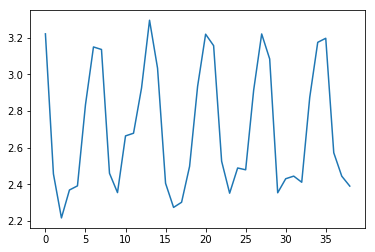

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.286069   
air_0164b9927d20bcc3_2017-04-23              1.421584   
air_0241aa3964b7f861_2017-04-23              2.336719   
air_0328696196e46f18_2017-04-23              2.039462   
air_034a3d5b40d5b1b1_2017-04-23              3.501011   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   8.836196  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.143680  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.347227  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.686472  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.148950

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/3001eb_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')